In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.append('/content/drive/MyDrive')
import helper as hp

# MLP

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dense, BatchNormalization, Dropout, Flatten, Activation
from keras.optimizers import Adam, RMSprop, SGD, Adagrad, Adadelta, Adamax, Nadam
from keras.metrics import SensitivityAtSpecificity
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, Callback
from keras.utils import np_utils
import keras.backend as K
import datetime

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_curve, auc, roc_auc_score
from itertools import cycle


In [16]:
from keras.datasets import fashion_mnist
(x_data, y_data), (x_test, y_test) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

# 20% del dataset para validación
validation = 0.20
N_validation_split = int(x_data.shape[0]*(1-validation))
# Training Set
x_train = x_data[:N_validation_split]
y_train = y_data[:N_validation_split]

# Cross Validation Set
x_val = x_data[N_validation_split:]
y_val = y_data[N_validation_split:]

# Data normalization
x_train = x_train.astype('float32') / 255
x_val = x_val.astype('float32') / 255
x_test = x_test.astype('float32') / 255



### Sparse arrays

In [17]:
y_sparse_train = np.zeros([len(y_train),10])
y_sparse_test = np.zeros([len(y_test),10])
for idx in range(len(y_train)):
    y_sparse_train[idx,y_train[idx]] = 1

for idx in range(len(y_test)):
    y_sparse_test[idx,y_test[idx]] = 1

### One hot encoding

In [18]:
y_train_categorical = np_utils.to_categorical(y_train)
y_val_categorical = np_utils.to_categorical(y_val)
print(y_train_categorical.shape)
for i in range(10):
    print(y_train[i], y_train_categorical[i])

(48000, 10)
9 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
0 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
0 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
7 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
2 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
5 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
5 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


### Single hidden layer:

### Let's check and compare the training and validation results with a single hidden layer.

In [10]:
import helper as hp

In [12]:
model_1_hidden = hp.classification_model(     x_train.shape,
                                    output_size = 10,
                                    hidden_layers_size = 1,
                                    hidden_layers_units = [256],
                                    hidden_activation = 'relu',
                                    kernel_initializer= 'random_normal',
                                    dropout_rate = [0.0],
                                    regularizer = None,
                                    regularizer_rate = 0.001,
                                    bias_initializer = 'zeros',
                                    use_batch_normalization=[False],
                                    lr = 0.0001,
                                    decay = 0,
                                    out_softmax = True,
                                    optimizer = Adam)
model_1_hidden.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               200960    
                                                                 
 Output (Dense)              (None, 10)                2570      
                                                                 
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________


### Accuracy of model previous to training

In [21]:
score = model_1_hidden.evaluate(x_val, y_val_categorical, verbose=0)
print("loss: ", score[0])
print("accuracy: ", score[1])

loss:  2.3542141914367676
accuracy:  0.11150000244379044


### Let's train (compile) this model:
This model has an early stopping callback.

In [23]:
model_trained = model_1_hidden.fit(x_train,
                                  y_sparse_train,
                                  epochs=512, batch_size=128,
                                  verbose=1,
                                  validation_data = (x_val, y_val_categorical),
                                  callbacks=[hp.callback_EarlyStopping()],
                                )

Epoch 1/512
375/375 [==============================] - 3s 5ms/step - loss: 0.9846 - accuracy: 0.7111 - f1_m: 0.5410 - precision_m: 0.8057 - recall_m: 0.4357 - val_loss: 0.6432 - val_accuracy: 0.7922 - val_f1_m: 0.7470 - val_precision_m: 0.8720 - val_recall_m: 0.6541
Epoch 2/512
375/375 [==============================] - 1s 3ms/step - loss: 0.5826 - accuracy: 0.8109 - f1_m: 0.7827 - precision_m: 0.8809 - recall_m: 0.7052 - val_loss: 0.5351 - val_accuracy: 0.8200 - val_f1_m: 0.8018 - val_precision_m: 0.8804 - val_recall_m: 0.7364
Epoch 3/512
375/375 [==============================] - 1s 3ms/step - loss: 0.5096 - accuracy: 0.8305 - f1_m: 0.8160 - precision_m: 0.8857 - recall_m: 0.7569 - val_loss: 0.4903 - val_accuracy: 0.8332 - val_f1_m: 0.8224 - val_precision_m: 0.8845 - val_recall_m: 0.7688
Epoch 4/512
375/375 [==============================] - 1s 3ms/step - loss: 0.4717 - accuracy: 0.8418 - f1_m: 0.8314 - precision_m: 0.8890 - recall_m: 0.7813 - val_loss: 0.4625 - val_accuracy: 0.8432 

### **Metrics!**

313/313 [==============================] - 1s 1ms/step
MLP 1 hidden layer:
  Accuracy: 0.8887500166893005
  Loss: 0.31341981887817383
  Precision: 0.9058700203895569
  Recall: 0.8731438517570496
  F1-score: 0.8891450762748718
  ROC AUC: 0.9902469777777778


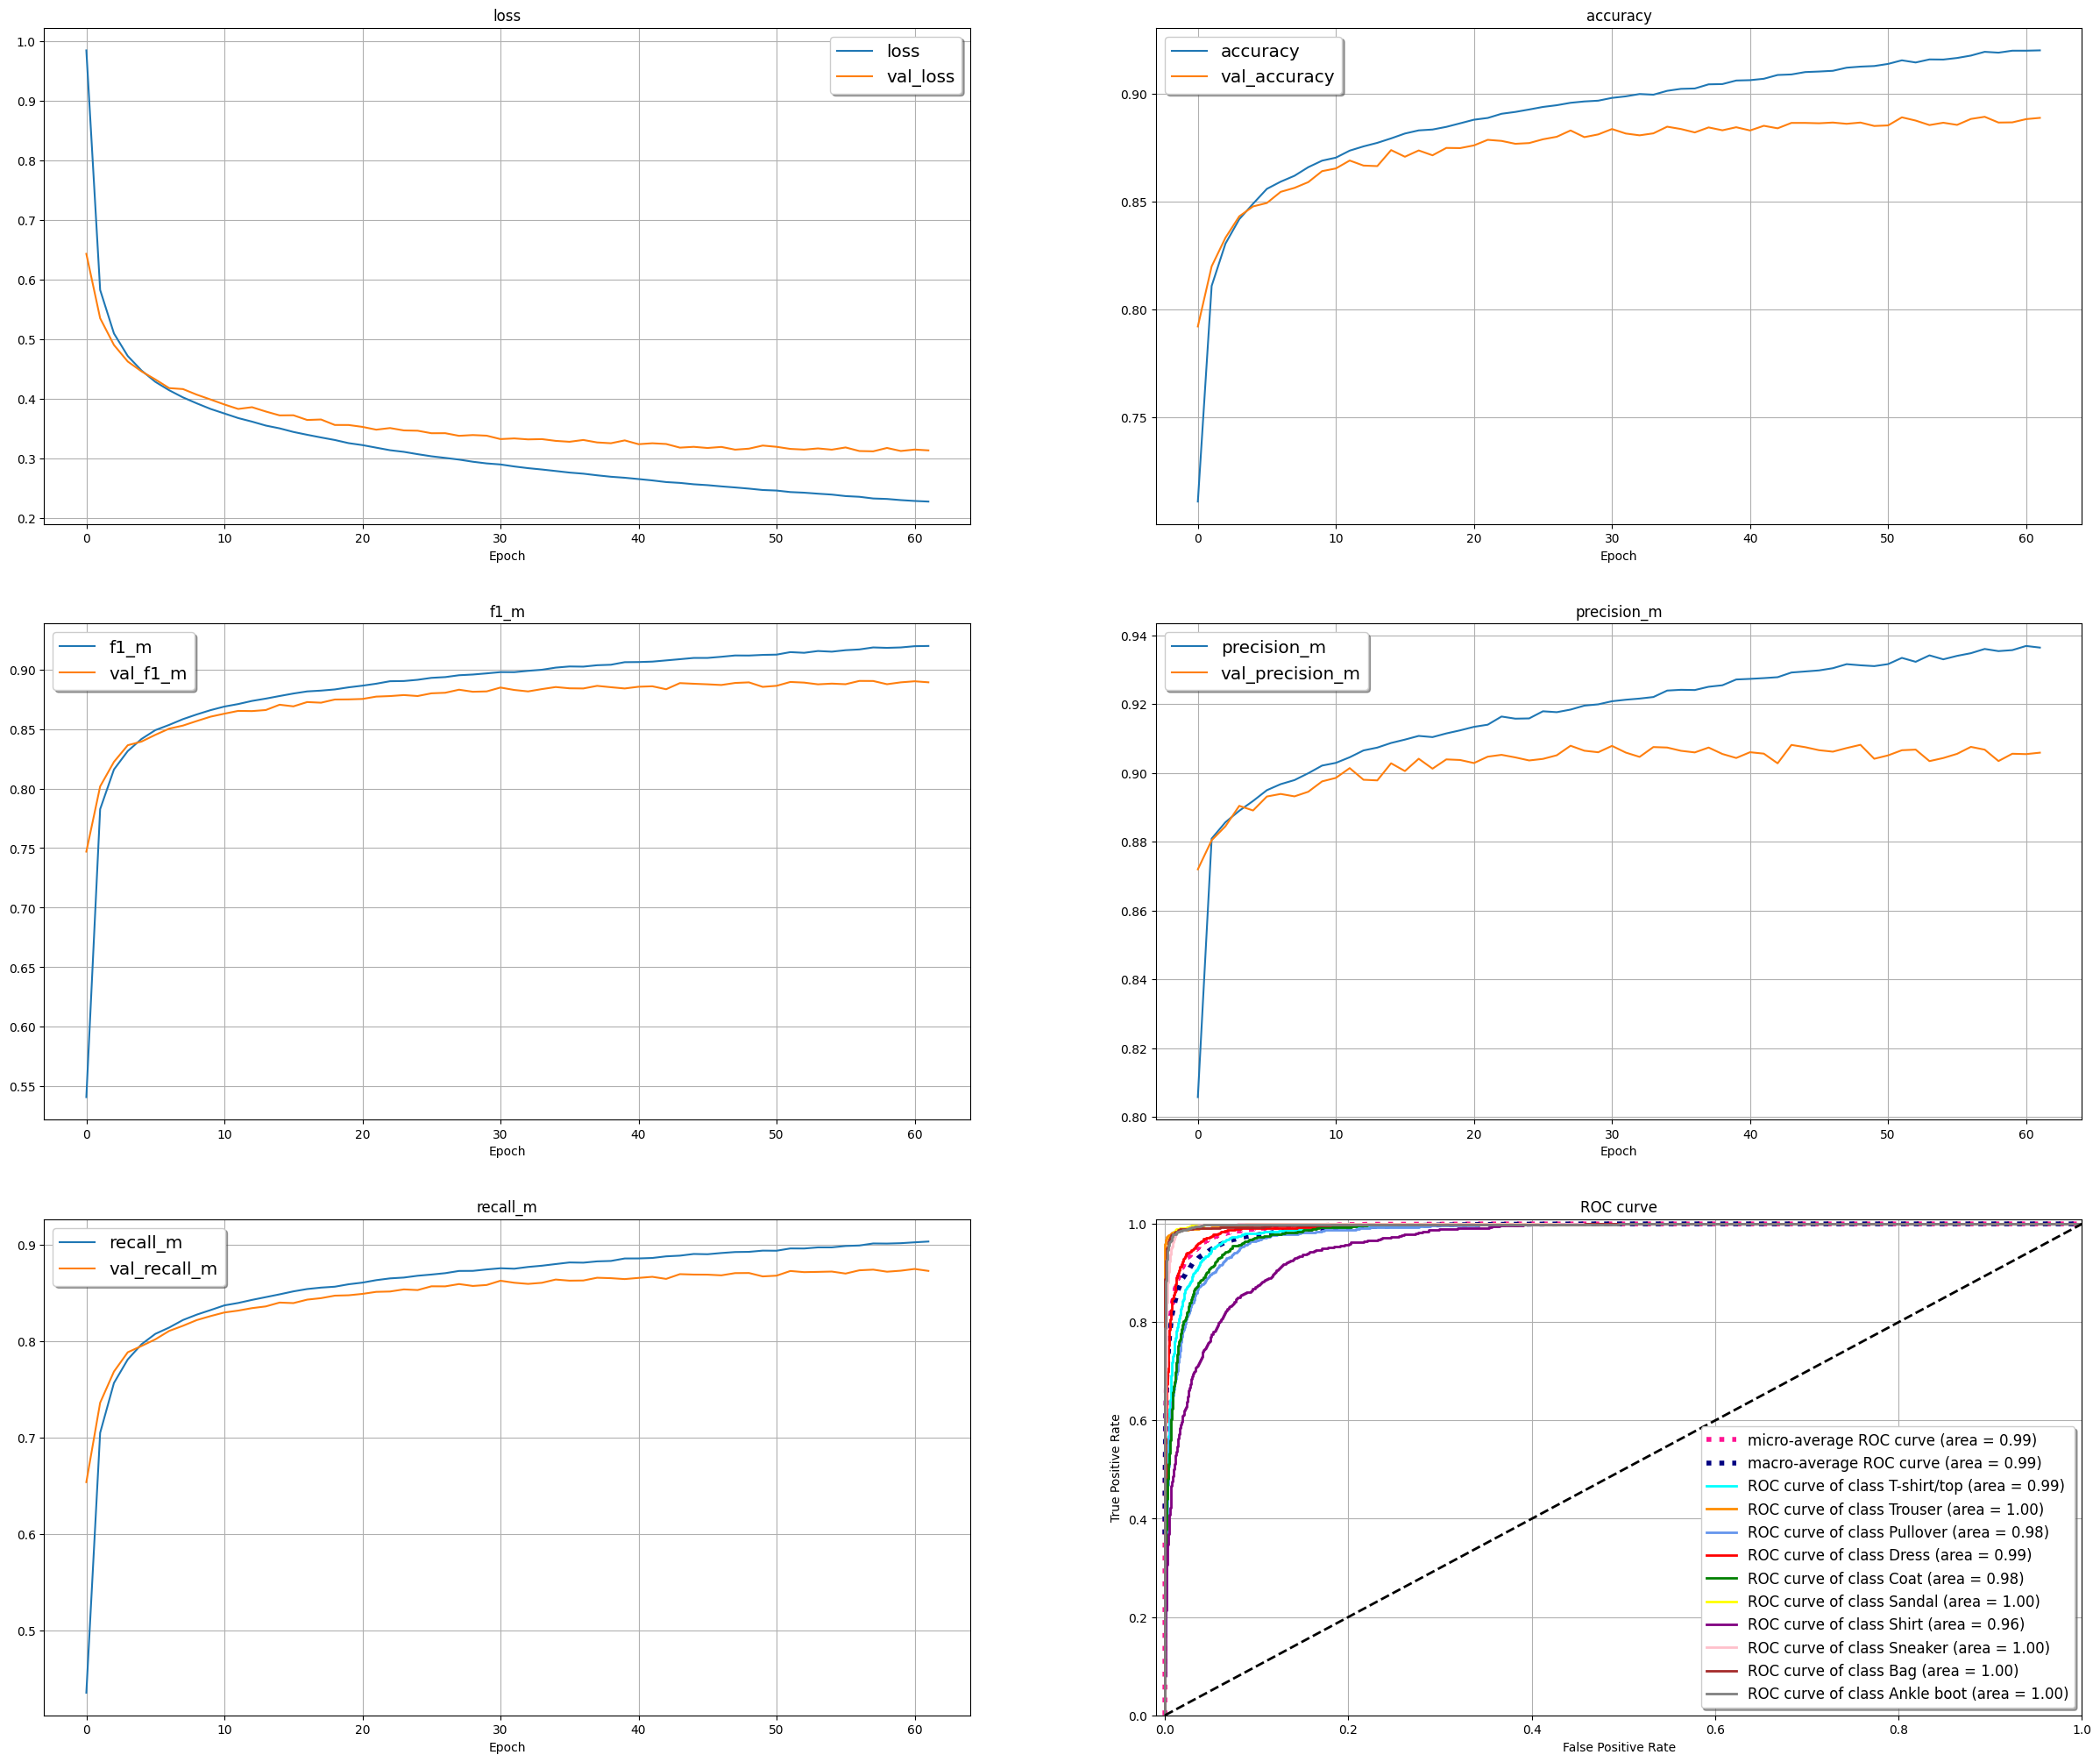

In [24]:
y_pred= model_1_hidden.predict(x_test)

# Print the evaluation metrics
print("MLP 1 hidden layer:")
print("  Accuracy:", model_trained.history['val_accuracy'][-1])
print("  Loss:", model_trained.history['val_loss'][-1])
print("  Precision:", model_trained.history['val_precision_m'][-1])
print("  Recall:", model_trained.history['val_recall_m'][-1])
print("  F1-score:", model_trained.history['val_f1_m'][-1])
print("  ROC AUC:", roc_auc_score(y_sparse_test, y_pred, multi_class='ovr', average="macro"))


metrics = [[['loss', "loss"],['val_loss',"val_loss"]],
            [['accuracy', "accuracy"],['val_accuracy', "val_accuracy"]],
            [['f1_m', "f1_m"],['val_f1_m', "val_f1_m"]],
            [['precision_m', "precision_m"],['val_precision_m', "val_precision_m"]],
            [['recall_m', "recall_m"],['val_recall_m', "val_recall_m"]],
            [['', ""],['', ""]]]

f, axis = plt.subplots(3, 2, figsize=(30, 25))
k = 0
for i in range(3):
    for j in range(2):
        if(k < 5):
            axis[i,j].plot(model_trained.history[metrics[k][0][0]], label = metrics[k][0][1])
            axis[i,j].plot(model_trained.history[metrics[k][1][0]], label = metrics[k][1][1])
            axis[i,j].grid()
            axis[i,j].set_xlabel('Epoch')
            axis[i,j].legend(shadow=True, fontsize='x-large')
            axis[i,j].set_title(metrics[k][0][1])
        else:
            lw=2
            fpr, tpr, roc_auc = hp.plot_ROC(y_sparse_test, y_pred, class_names)
            axis[i,j].plot(fpr["micro"], tpr["micro"],
                        label='micro-average ROC curve (area = {0:0.2f})'
                            ''.format(roc_auc["micro"]),
                        color='deeppink', linestyle=':', linewidth=4)

            axis[i,j].plot(fpr["macro"], tpr["macro"],
                        label='macro-average ROC curve (area = {0:0.2f})'
                            ''.format(roc_auc["macro"]),
                        color='navy', linestyle=':', linewidth=4)

            colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'yellow', 'purple', 'pink', 'brown', 'gray'])
            for h, color in zip(range(len(class_names)), colors):
                axis[i,j].plot(fpr[h], tpr[h], color=color, lw=lw,
                            label='ROC curve of class {0} (area = {1:0.2f})'
                            ''.format(class_names[h], roc_auc[h]))

            axis[i,j].plot([0, 1], [0, 1], 'k--', lw=lw)
            axis[i,j].set_xlim([-0.01, 1.0])
            axis[i,j].set_ylim([0.0, 1.01])
            axis[i,j].set_xlabel('False Positive Rate')
            axis[i,j].set_ylabel('True Positive Rate')
            axis[i,j].set_title('ROC curve')
            axis[i,j].grid()
            axis[i,j].legend(loc="lower right", shadow=True, fontsize='large')
        k += 1



There is overfitting as we see in the Accuracy metric, much more than in the case of the softmax.

**Micro-average** "takes imbalance into account" in the sense that the resulting performance is based on the proportion of every class, i.e. the performance of a large class has more impact on the result than of a small class.
**Macro-average** "doesn't take imbalance into account" in the sense that the resulting performance is a simple average over the classes, so every class is given equal weight independently from their proportion.

https://datascience.stackexchange.com/questions/85981/micro-average-vs-macro-average-for-class-imbalance

**As we have uniformly distributed classes, we will use the macro-average for computing the ROC curve.**

## Comparison of different layer sizes:

In [25]:

neurons_1hidden = [8, 16, 32, 64, 128, 512, 1028]

accuracies_neurons_1hidden= []
losses_neurons_1hidden = []
histories_neurons_1hidden = []
for n in neurons_1hidden:
    K.clear_session()
    model_neurons_1hidden = hp.classification_model(     x_train.shape,
                                    output_size = 10,
                                    hidden_layers_size = 1,
                                    hidden_layers_units = [n],
                                    hidden_activation = 'relu',
                                    kernel_initializer= 'random_normal',
                                    dropout_rate = [0.0],
                                    regularizer = None,
                                    regularizer_rate = 0.001,
                                    bias_initializer = 'zeros',
                                    use_batch_normalization=[False],
                                    lr = 0.0001,
                                    decay = 0,
                                    out_softmax = True,
                                    optimizer = Adam)
    model_trained_neurons_1hidden = model_neurons_1hidden.fit(    x_train,
                                  y_sparse_train,
                                  epochs=512, batch_size=128,
                                  verbose=0,
                                  validation_data = (x_val, y_val_categorical),
                                  callbacks=[hp.callback_EarlyStopping()],
                                )
    accuracies_neurons_1hidden.append(model_trained_neurons_1hidden.history['val_accuracy'])
    losses_neurons_1hidden.append(model_trained_neurons_1hidden.history['val_loss'])
    histories_neurons_1hidden.append(model_trained_neurons_1hidden.history)

Epoch 102: early stopping
Epoch 76: early stopping
Epoch 90: early stopping
Epoch 75: early stopping
Epoch 75: early stopping
Epoch 54: early stopping
Epoch 42: early stopping


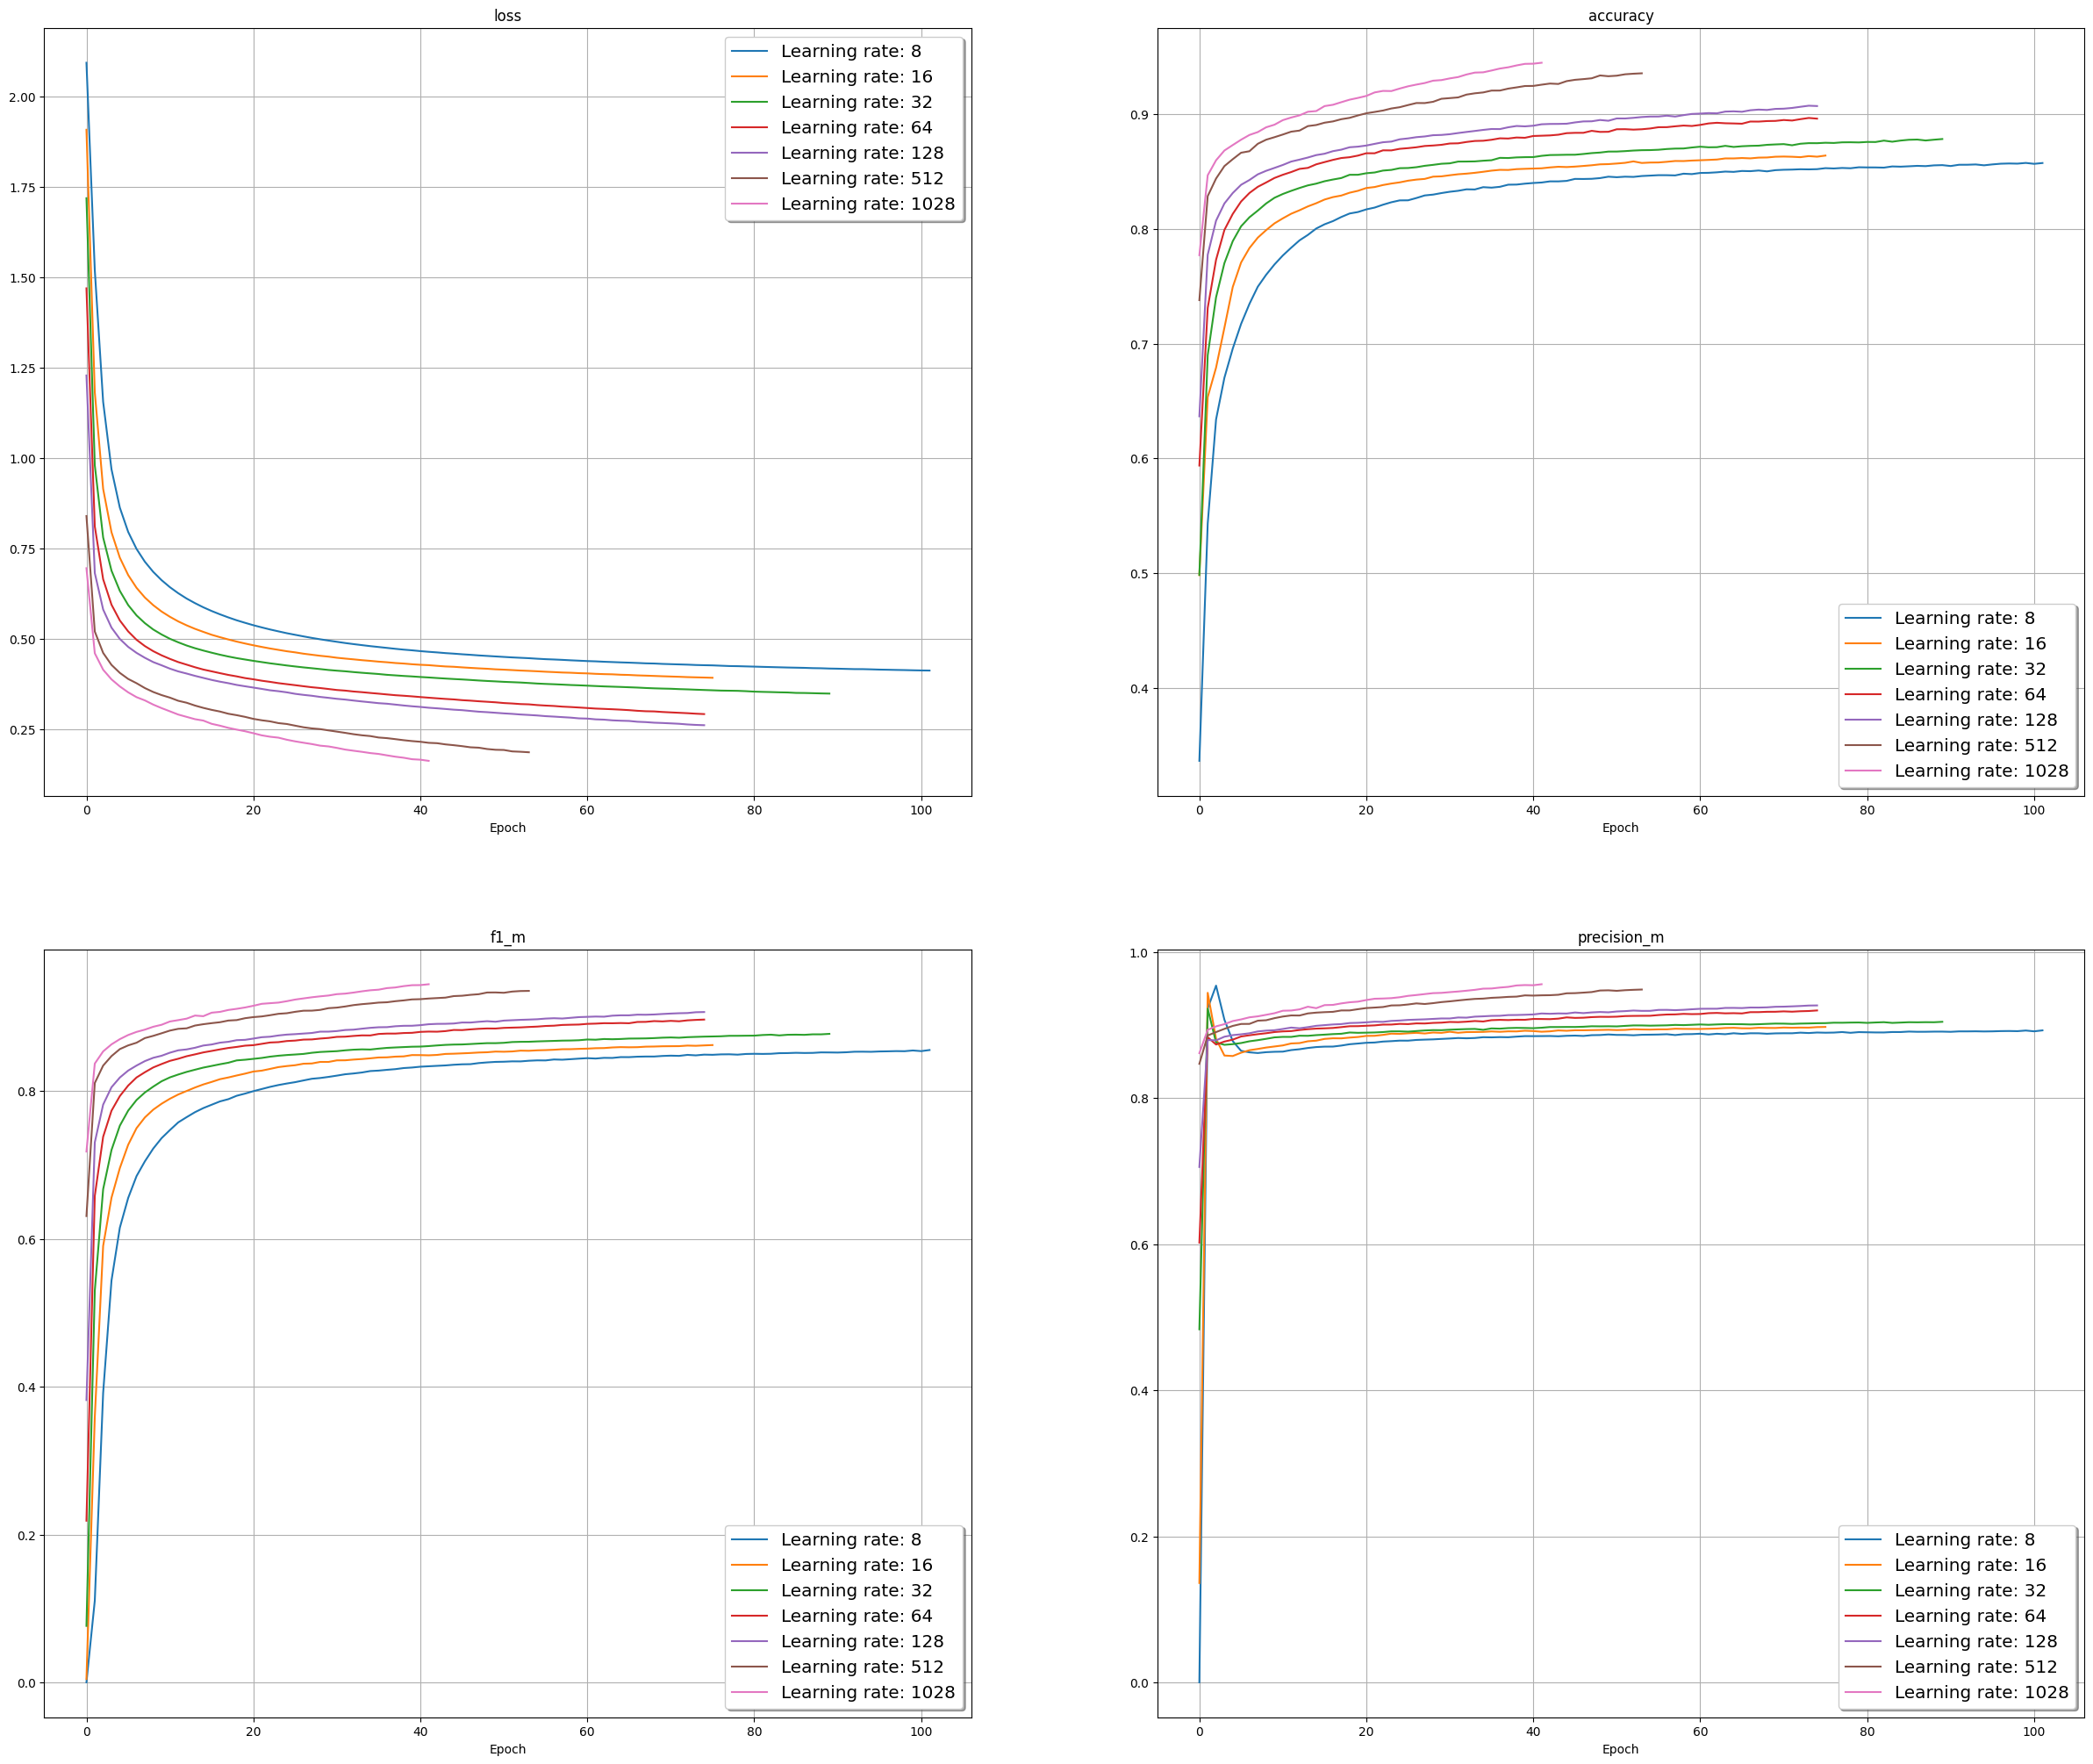

In [26]:
f, axis = plt.subplots(2, 2, figsize=(30, 25))
k = 0
for i in range(2):
    for j in range(2):
      for n in range(len(neurons_1hidden)):
        axis[i,j].plot(histories_neurons_1hidden[n][metrics[k][0][0]], label=f'Learning rate: {neurons_1hidden[n]}')
        axis[i,j].grid()
        axis[i,j].set_xlabel('Epoch')
        axis[i,j].legend(shadow=True, fontsize='x-large')
        axis[i,j].set_title(metrics[k][0][1])
      k += 1
plt.show()


8  neurons --- accuracy:  0.8507500290870667  --- loss:  0.430107980966568
16  neurons --- accuracy:  0.8557500243186951  --- loss:  0.41465678811073303
32  neurons --- accuracy:  0.8664166927337646  --- loss:  0.3851058781147003
64  neurons --- accuracy:  0.8791666626930237  --- loss:  0.34118491411209106
128  neurons --- accuracy:  0.8827499747276306  --- loss:  0.33430513739585876
512  neurons --- accuracy:  0.8954166769981384  --- loss:  0.2939383089542389
1028  neurons --- accuracy:  0.8926666378974915  --- loss:  0.2972537577152252


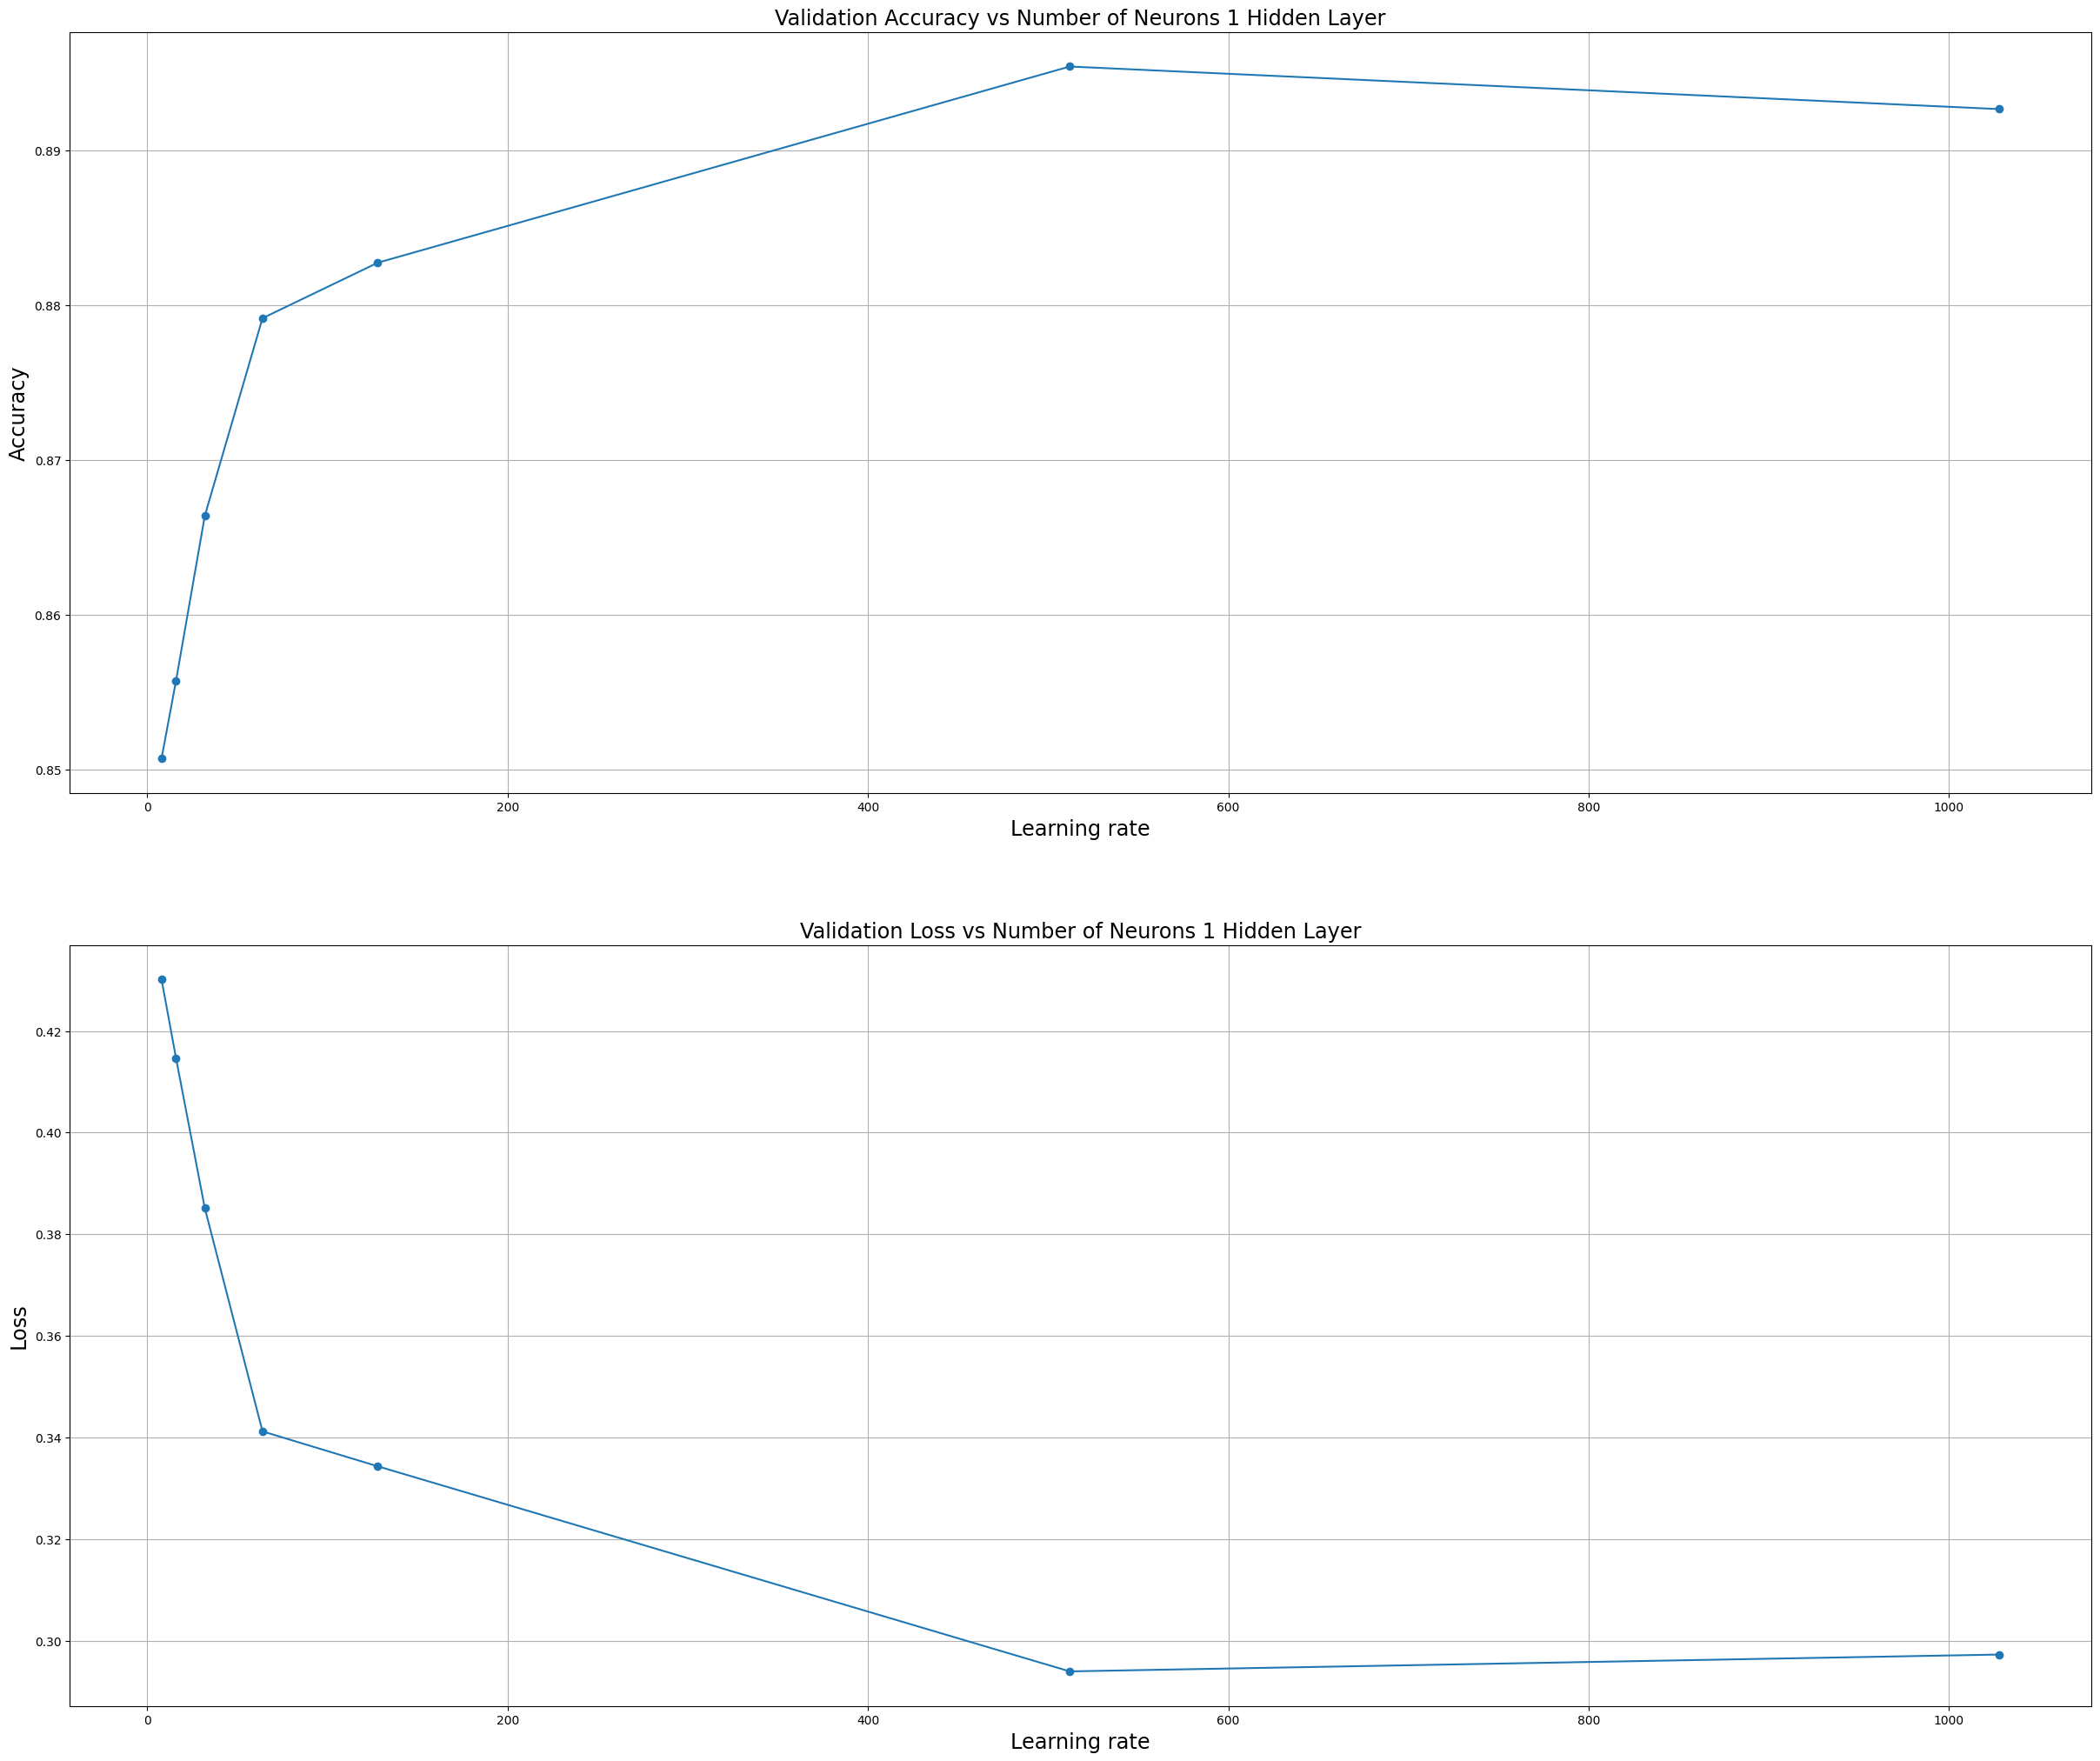

In [28]:
final_accuracies = [acc[-1] for acc in accuracies_neurons_1hidden]
final_losses = [loss[-1] for loss in losses_neurons_1hidden]

for i in range(len(neurons_1hidden)):
  print(neurons_1hidden[i]," neurons --- accuracy: ", final_accuracies[i], " --- loss: ", final_losses[i])

# Plotting accuracies
f, axis = plt.subplots(2, 1, figsize=(30, 25))
axis[0].plot(neurons_1hidden, final_accuracies, marker = 'o')
axis[0].set_xlabel('Learning rate', fontsize='xx-large')
axis[0].set_ylabel('Accuracy', fontsize='xx-large')
axis[0].set_title('Validation Accuracy vs Number of Neurons 1 Hidden Layer', fontsize='xx-large')
#axis[0].set_xscale('log')
axis[0].grid()

# Plotting losses
axis[1].plot(neurons_1hidden, final_losses, marker = 'o')
axis[1].set_xlabel('Learning rate', fontsize='xx-large')
axis[1].set_ylabel('Loss', fontsize='xx-large')
axis[1].set_title('Validation Loss vs Number of Neurons 1 Hidden Layer', fontsize='xx-large')
#axis[1].set_xscale('log')
axis[1].grid()

plt.show()

Indeed, more neurons in a single layer results in a better overall performance: less epochs, better accuracy and smaller loss. BUT, see that 512 is a good number.

**Note**: it takes A LOT OF TIME to run this test... with more layers I guess it will get even worse.

## 2 Hidden layers

In [29]:
K.clear_session()

model_2_hidden = hp.classification_model(     x_train.shape,
                                    output_size = 10,
                                    hidden_layers_size = 2,
                                    hidden_layers_units = [512, 256],
                                    hidden_activation = 'relu',
                                    kernel_initializer= 'random_normal',
                                    dropout_rate = [0.0, 0.0],
                                    regularizer = None,
                                    regularizer_rate = 0.001,
                                    bias_initializer = 'zeros',
                                    use_batch_normalization=[False, False],
                                    lr = 0.0001,
                                    decay = 0,
                                    out_softmax = True,
                                    optimizer = Adam)
model_2_hidden.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 Output (Dense)              (None, 10)                2570      
                                                                 
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
_________________________________________________________________


Without training:

In [30]:
score = model_2_hidden.evaluate(x_val, y_val_categorical, verbose=0)
print("loss: ", score[0])
print("accuracy: ", score[1])

loss:  2.370561122894287
accuracy:  0.11550000309944153


In [31]:
model_trained_2 = model_2_hidden.fit(x_train,
                                  y_sparse_train,
                                  epochs=512, batch_size=128,
                                  verbose=1,
                                  validation_data = (x_val, y_val_categorical),
                                  callbacks=[hp.callback_EarlyStopping()],
                                )

Epoch 1/512
375/375 [==============================] - 3s 6ms/step - loss: 0.7980 - accuracy: 0.7514 - f1_m: 0.6484 - precision_m: 0.8205 - recall_m: 0.5649 - val_loss: 0.5201 - val_accuracy: 0.8201 - val_f1_m: 0.8050 - val_precision_m: 0.8745 - val_recall_m: 0.7462
Epoch 2/512
375/375 [==============================] - 1s 4ms/step - loss: 0.4700 - accuracy: 0.8394 - f1_m: 0.8288 - precision_m: 0.8871 - recall_m: 0.7781 - val_loss: 0.4440 - val_accuracy: 0.8430 - val_f1_m: 0.8376 - val_precision_m: 0.8882 - val_recall_m: 0.7928
Epoch 3/512
375/375 [==============================] - 1s 4ms/step - loss: 0.4197 - accuracy: 0.8540 - f1_m: 0.8496 - precision_m: 0.8938 - recall_m: 0.8098 - val_loss: 0.4400 - val_accuracy: 0.8471 - val_f1_m: 0.8443 - val_precision_m: 0.8812 - val_recall_m: 0.8105
Epoch 4/512
375/375 [==============================] - 1s 4ms/step - loss: 0.3906 - accuracy: 0.8643 - f1_m: 0.8604 - precision_m: 0.8981 - recall_m: 0.8259 - val_loss: 0.3973 - val_accuracy: 0.8602 

Metrics with 2 hidden layers!

313/313 [==============================] - 1s 2ms/step
MLP 2 hidden layer:
  Accuracy: 0.8943333625793457
  Loss: 0.3163864314556122
  Precision: 0.9031659364700317
  Recall: 0.8859153389930725
  F1-score: 0.8944199085235596
  ROC AUC: 0.9915164944444446


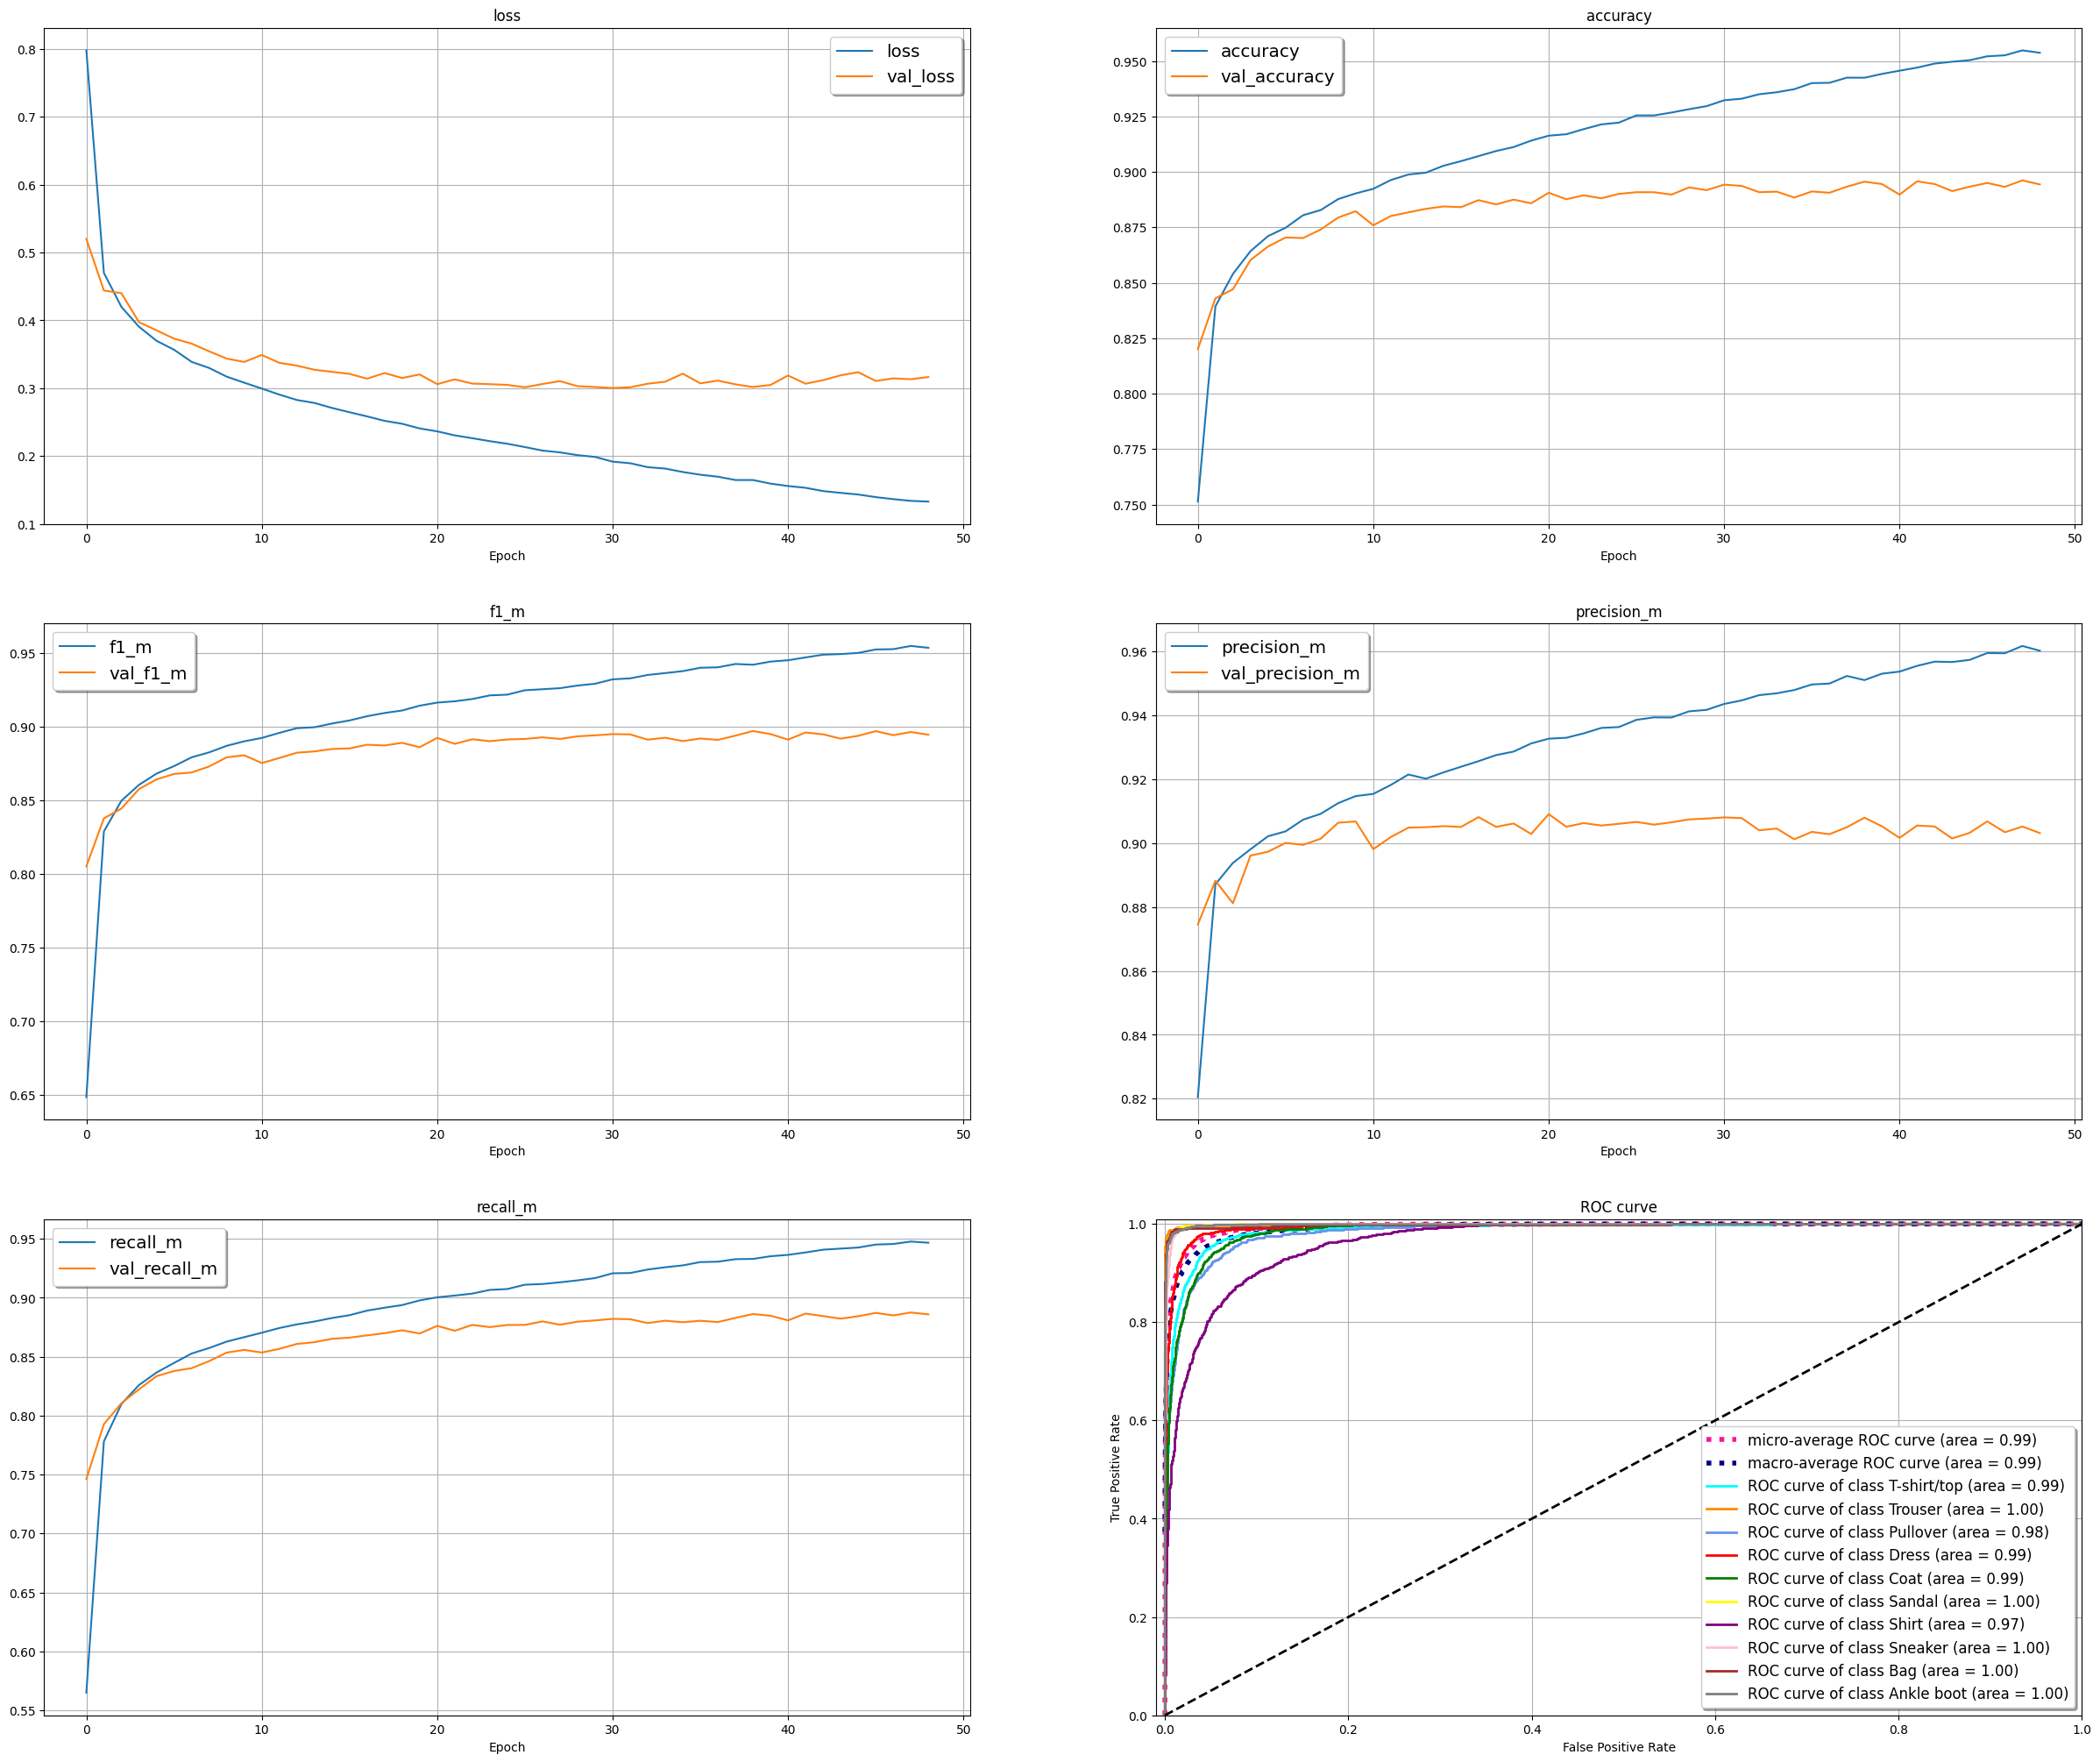

In [32]:
y_pred= model_2_hidden.predict(x_test)

# Print the evaluation metrics
print("MLP 2 hidden layer:")
print("  Accuracy:", model_trained_2.history['val_accuracy'][-1])
print("  Loss:", model_trained_2.history['val_loss'][-1])
print("  Precision:", model_trained_2.history['val_precision_m'][-1])
print("  Recall:", model_trained_2.history['val_recall_m'][-1])
print("  F1-score:", model_trained_2.history['val_f1_m'][-1])
print("  ROC AUC:", roc_auc_score(y_sparse_test, y_pred, multi_class='ovr', average="macro"))


metrics = [[['loss', "loss"],['val_loss',"val_loss"]],
            [['accuracy', "accuracy"],['val_accuracy', "val_accuracy"]],
            [['f1_m', "f1_m"],['val_f1_m', "val_f1_m"]],
            [['precision_m', "precision_m"],['val_precision_m', "val_precision_m"]],
            [['recall_m', "recall_m"],['val_recall_m', "val_recall_m"]],
            [['', ""],['', ""]]]

f, axis = plt.subplots(3, 2, figsize=(30, 25))
k = 0
for i in range(3):
    for j in range(2):
        if(k < 5):
            axis[i,j].plot(model_trained_2.history[metrics[k][0][0]], label = metrics[k][0][1])
            axis[i,j].plot(model_trained_2.history[metrics[k][1][0]], label = metrics[k][1][1])
            axis[i,j].grid()
            axis[i,j].set_xlabel('Epoch')
            axis[i,j].legend(shadow=True, fontsize='x-large')
            axis[i,j].set_title(metrics[k][0][1])
        else:
            lw=2
            fpr, tpr, roc_auc = hp.plot_ROC(y_sparse_test, y_pred, class_names)
            axis[i,j].plot(fpr["micro"], tpr["micro"],
                        label='micro-average ROC curve (area = {0:0.2f})'
                            ''.format(roc_auc["micro"]),
                        color='deeppink', linestyle=':', linewidth=4)

            axis[i,j].plot(fpr["macro"], tpr["macro"],
                        label='macro-average ROC curve (area = {0:0.2f})'
                            ''.format(roc_auc["macro"]),
                        color='navy', linestyle=':', linewidth=4)

            colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'yellow', 'purple', 'pink', 'brown', 'gray'])
            for h, color in zip(range(len(class_names)), colors):
                axis[i,j].plot(fpr[h], tpr[h], color=color, lw=lw,
                            label='ROC curve of class {0} (area = {1:0.2f})'
                            ''.format(class_names[h], roc_auc[h]))

            axis[i,j].plot([0, 1], [0, 1], 'k--', lw=lw)
            axis[i,j].set_xlim([-0.01, 1.0])
            axis[i,j].set_ylim([0.0, 1.01])
            axis[i,j].set_xlabel('False Positive Rate')
            axis[i,j].set_ylabel('True Positive Rate')
            axis[i,j].set_title('ROC curve')
            axis[i,j].grid()
            axis[i,j].legend(loc="lower right", shadow=True, fontsize='large')
        k += 1



We got a slightly better accuracy... but the overfitting is worse. Before trying to solve that, let's see if we can check the number of neurons in the layers:

## Comparison of different layer sizes for 2 hidden layers:

Let's see what happen with different combination of sizes in the layers:

In [33]:

neurons_2hidden = [[512, 256], [256, 128], [512, 128], [1024, 64]]

accuracies_neurons_2hidden= []
losses_neurons_2hidden = []
histories_neurons_2hidden = []
for n in neurons_2hidden:
    K.clear_session()
    model_neurons_2hidden = hp.classification_model(     x_train.shape,
                                    output_size = 10,
                                    hidden_layers_size = 1,
                                    hidden_layers_units = n,
                                    hidden_activation = 'relu',
                                    kernel_initializer= 'random_normal',
                                    dropout_rate = [0.0, 0.0],
                                    regularizer = None,
                                    regularizer_rate = 0.001,
                                    bias_initializer = 'zeros',
                                    use_batch_normalization=[False, False],
                                    lr = 0.0001,
                                    decay = 0,
                                    out_softmax = True,
                                    optimizer = Adam)
    model_trained_neurons_2hidden = model_neurons_2hidden.fit(    x_train,
                                  y_sparse_train,
                                  epochs=512, batch_size=128,
                                  verbose=0,
                                  validation_data = (x_val, y_val_categorical),
                                  callbacks=[hp.callback_EarlyStopping()],
                                )
    accuracies_neurons_2hidden.append(model_trained_neurons_2hidden.history['val_accuracy'])
    losses_neurons_2hidden.append(model_trained_neurons_2hidden.history['val_loss'])
    histories_neurons_2hidden.append(model_trained_neurons_2hidden.history)

Epoch 62: early stopping
Epoch 68: early stopping
Epoch 65: early stopping
Epoch 37: early stopping


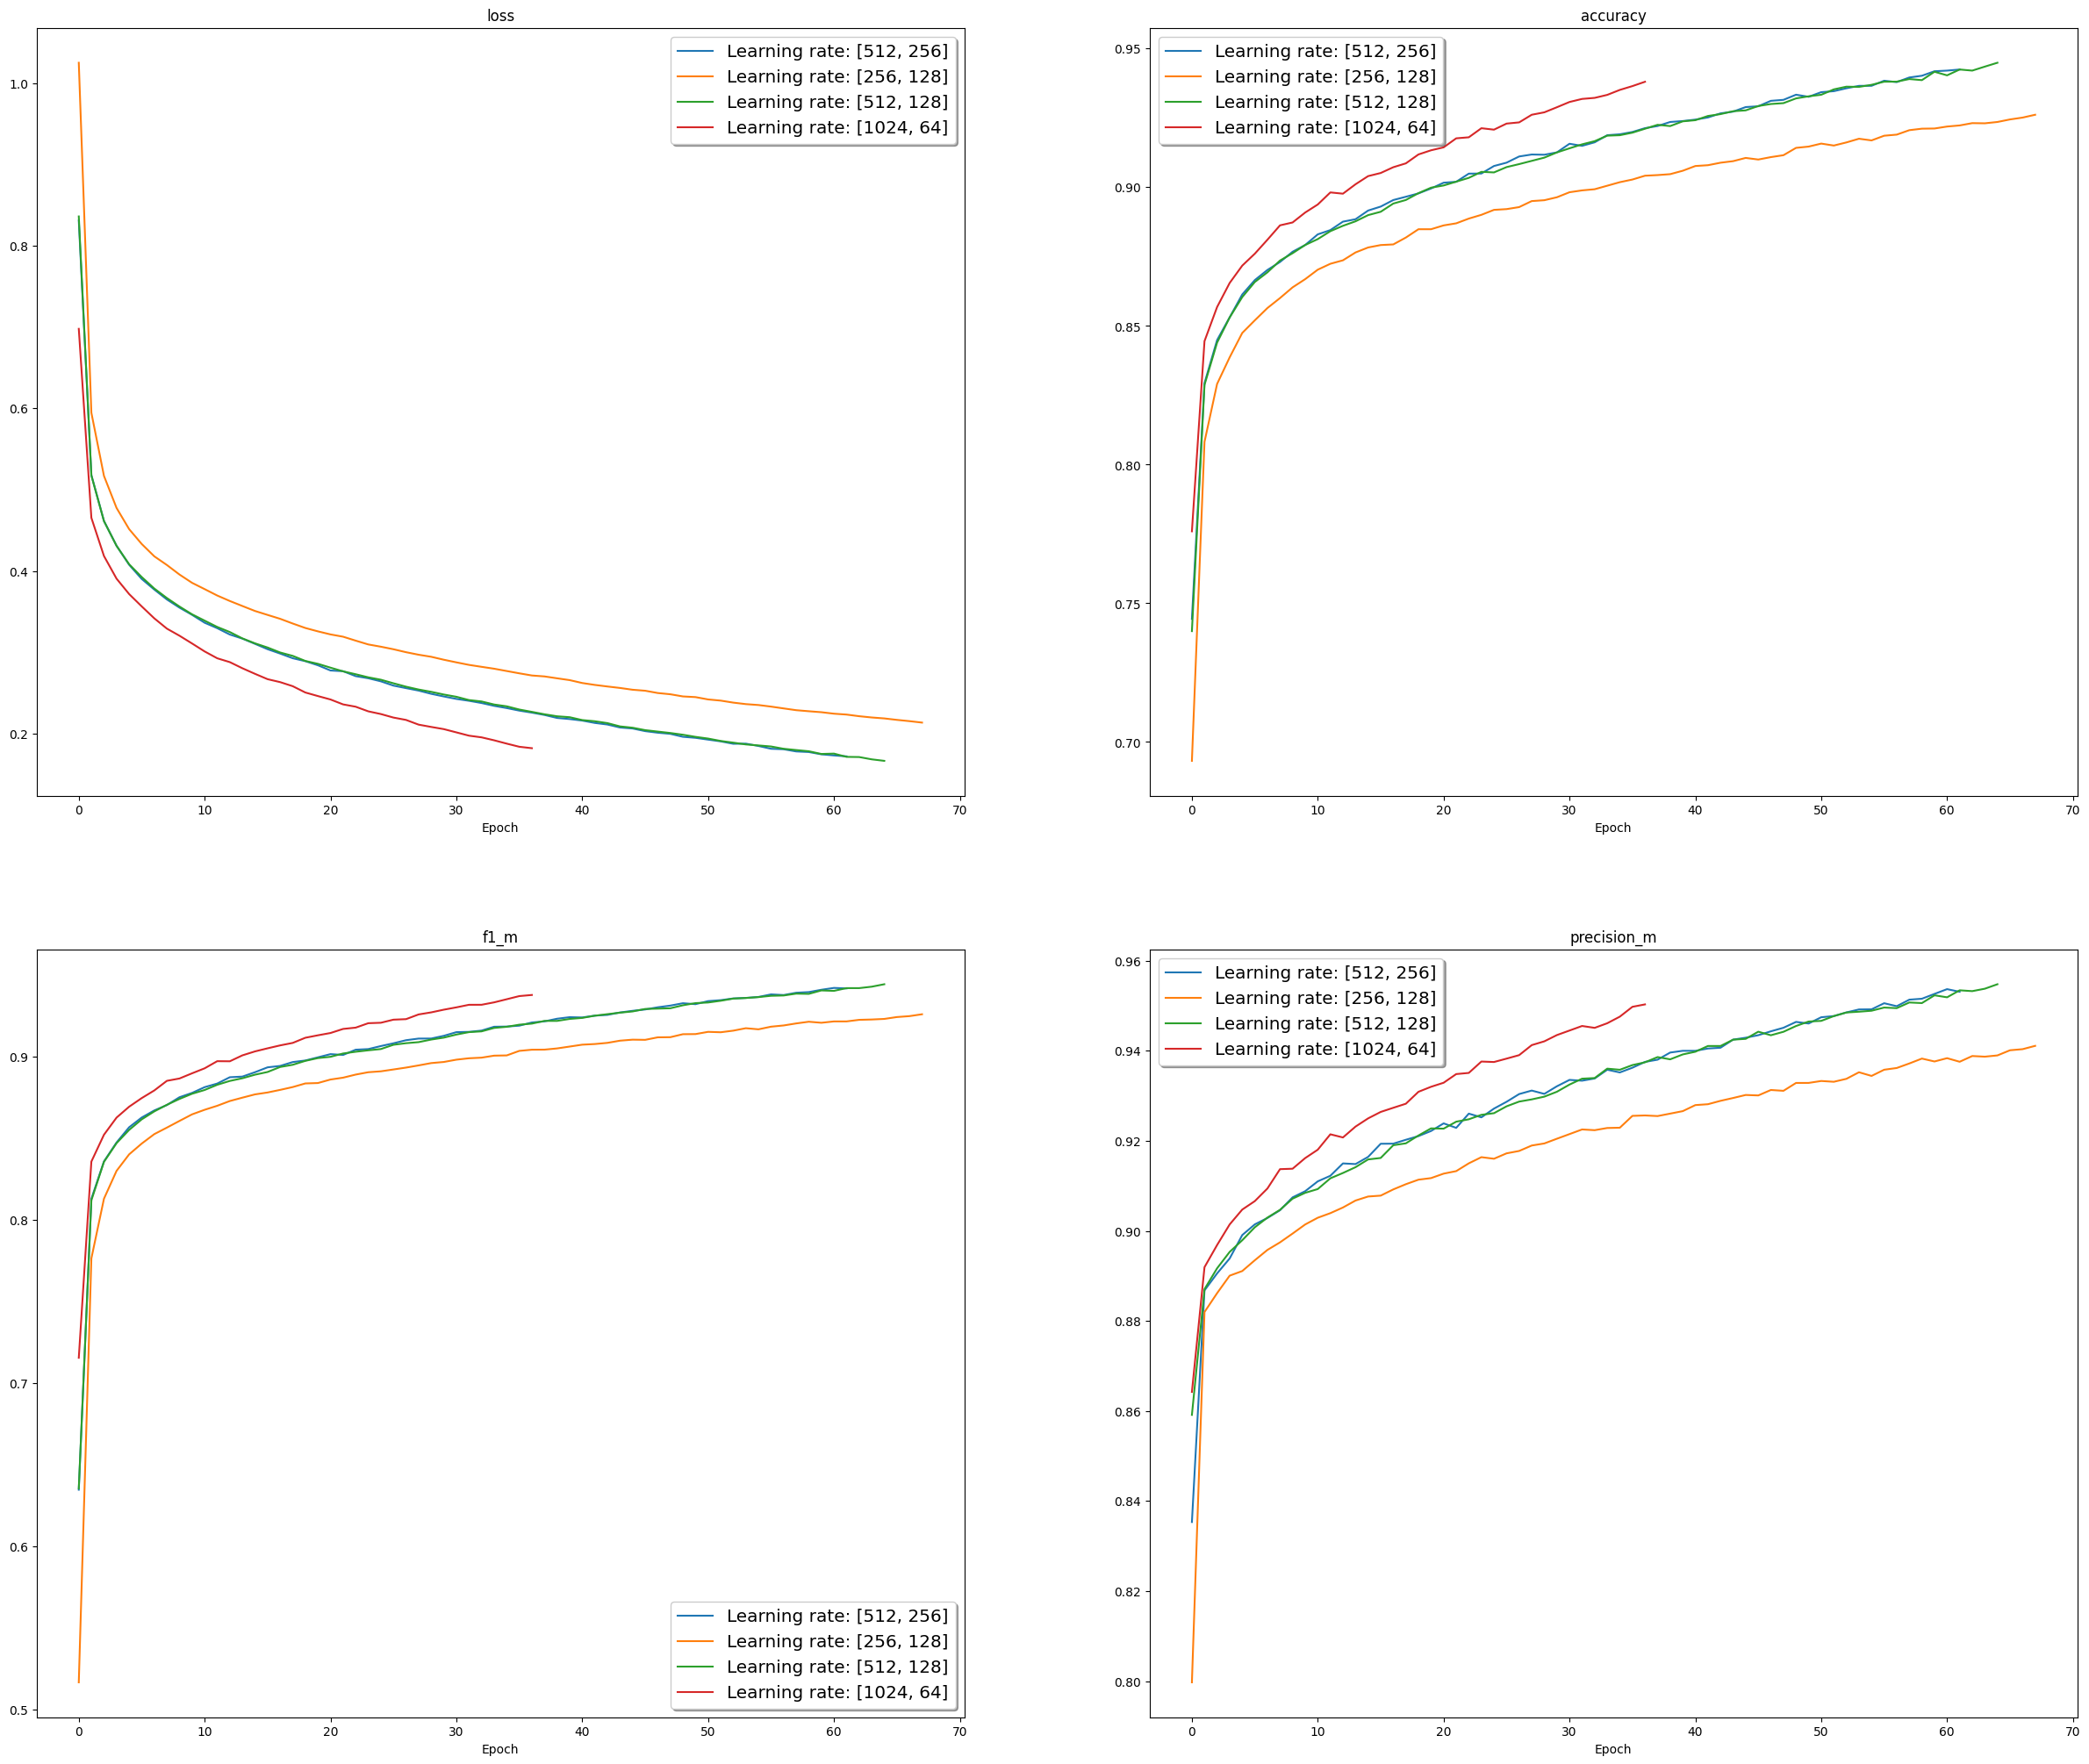

In [34]:
f, axis = plt.subplots(2, 2, figsize=(30, 25))
k = 0
for i in range(2):
    for j in range(2):
      for n in range(len(neurons_2hidden)):
        axis[i,j].plot(histories_neurons_2hidden[n][metrics[k][0][0]], label=f'Learning rate: {neurons_2hidden[n]}')
        axis[i,j].grid()
        axis[i,j].set_xlabel('Epoch')
        axis[i,j].legend(shadow=True, fontsize='x-large')
        axis[i,j].set_title(metrics[k][0][1])
      k += 1
plt.show()


In [36]:
final_accuracies = [acc[-1] for acc in accuracies_neurons_2hidden]
final_losses = [loss[-1] for loss in losses_neurons_2hidden]

for i in range(len(neurons_2hidden)):
  print(neurons_2hidden[i]," neurons --- accuracy: ", final_accuracies[i], " --- loss: ", final_losses[i])

#Here the plots were not that nice so it is better to just compare the numerical results:

[512, 256]  neurons --- accuracy:  0.8934166431427002  --- loss:  0.29733341932296753
[256, 128]  neurons --- accuracy:  0.890333354473114  --- loss:  0.30826035141944885
[512, 128]  neurons --- accuracy:  0.8946666717529297  --- loss:  0.3013744652271271
[1024, 64]  neurons --- accuracy:  0.8890833258628845  --- loss:  0.30369871854782104


And we see that, effectively, keeping a 512 neurons layer at the beginning is the best option. Let's keep it.

## 3 Hidden layers

In [39]:
K.clear_session()

model_3_hidden = hp.classification_model(     x_train.shape,
                                    output_size = 10,
                                    hidden_layers_size = 3,
                                    hidden_layers_units = [512, 128, 64],
                                    hidden_activation = 'relu',
                                    kernel_initializer= 'random_normal',
                                    dropout_rate = [0.0, 0.0, 0.0],
                                    regularizer = None,
                                    regularizer_rate = 0.001,
                                    bias_initializer = 'zeros',
                                    use_batch_normalization=[False, False, False],
                                    lr = 0.0001,
                                    decay = 0,
                                    out_softmax = True,
                                    optimizer = Adam)
model_3_hidden.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 Output (Dense)              (None, 10)                650       
                                                                 
Total params: 476,490
Trainable params: 476,490
Non-trainable params: 0
_________________________________________________________________


In [40]:
model_trained_3 = model_3_hidden.fit(x_train,
                                  y_sparse_train,
                                  epochs=512, batch_size=128,
                                  verbose=1,
                                  validation_data = (x_val, y_val_categorical),
                                  callbacks=[hp.callback_EarlyStopping()],
                                )

Epoch 1/512
375/375 [==============================] - 2s 5ms/step - loss: 1.0859 - accuracy: 0.6678 - f1_m: 0.4887 - precision_m: 0.7068 - recall_m: 0.4003 - val_loss: 0.6184 - val_accuracy: 0.7931 - val_f1_m: 0.7611 - val_precision_m: 0.8731 - val_recall_m: 0.6753
Epoch 2/512
375/375 [==============================] - 1s 4ms/step - loss: 0.5448 - accuracy: 0.8114 - f1_m: 0.7945 - precision_m: 0.8743 - recall_m: 0.7289 - val_loss: 0.5033 - val_accuracy: 0.8248 - val_f1_m: 0.8150 - val_precision_m: 0.8749 - val_recall_m: 0.7630
Epoch 3/512
375/375 [==============================] - 1s 4ms/step - loss: 0.4716 - accuracy: 0.8364 - f1_m: 0.8274 - precision_m: 0.8812 - recall_m: 0.7803 - val_loss: 0.4577 - val_accuracy: 0.8406 - val_f1_m: 0.8357 - val_precision_m: 0.8843 - val_recall_m: 0.7924
Epoch 4/512
375/375 [==============================] - 2s 4ms/step - loss: 0.4382 - accuracy: 0.8463 - f1_m: 0.8411 - precision_m: 0.8855 - recall_m: 0.8014 - val_loss: 0.4359 - val_accuracy: 0.8485 

313/313 [==============================] - 1s 1ms/step
MLP 3 hidden layers:
  Accuracy: 0.8940833210945129
  Loss: 0.3251706063747406
  Precision: 0.9035918712615967
  Recall: 0.8850288391113281
  F1-score: 0.894182026386261
  ROC AUC: 0.9910523555555557


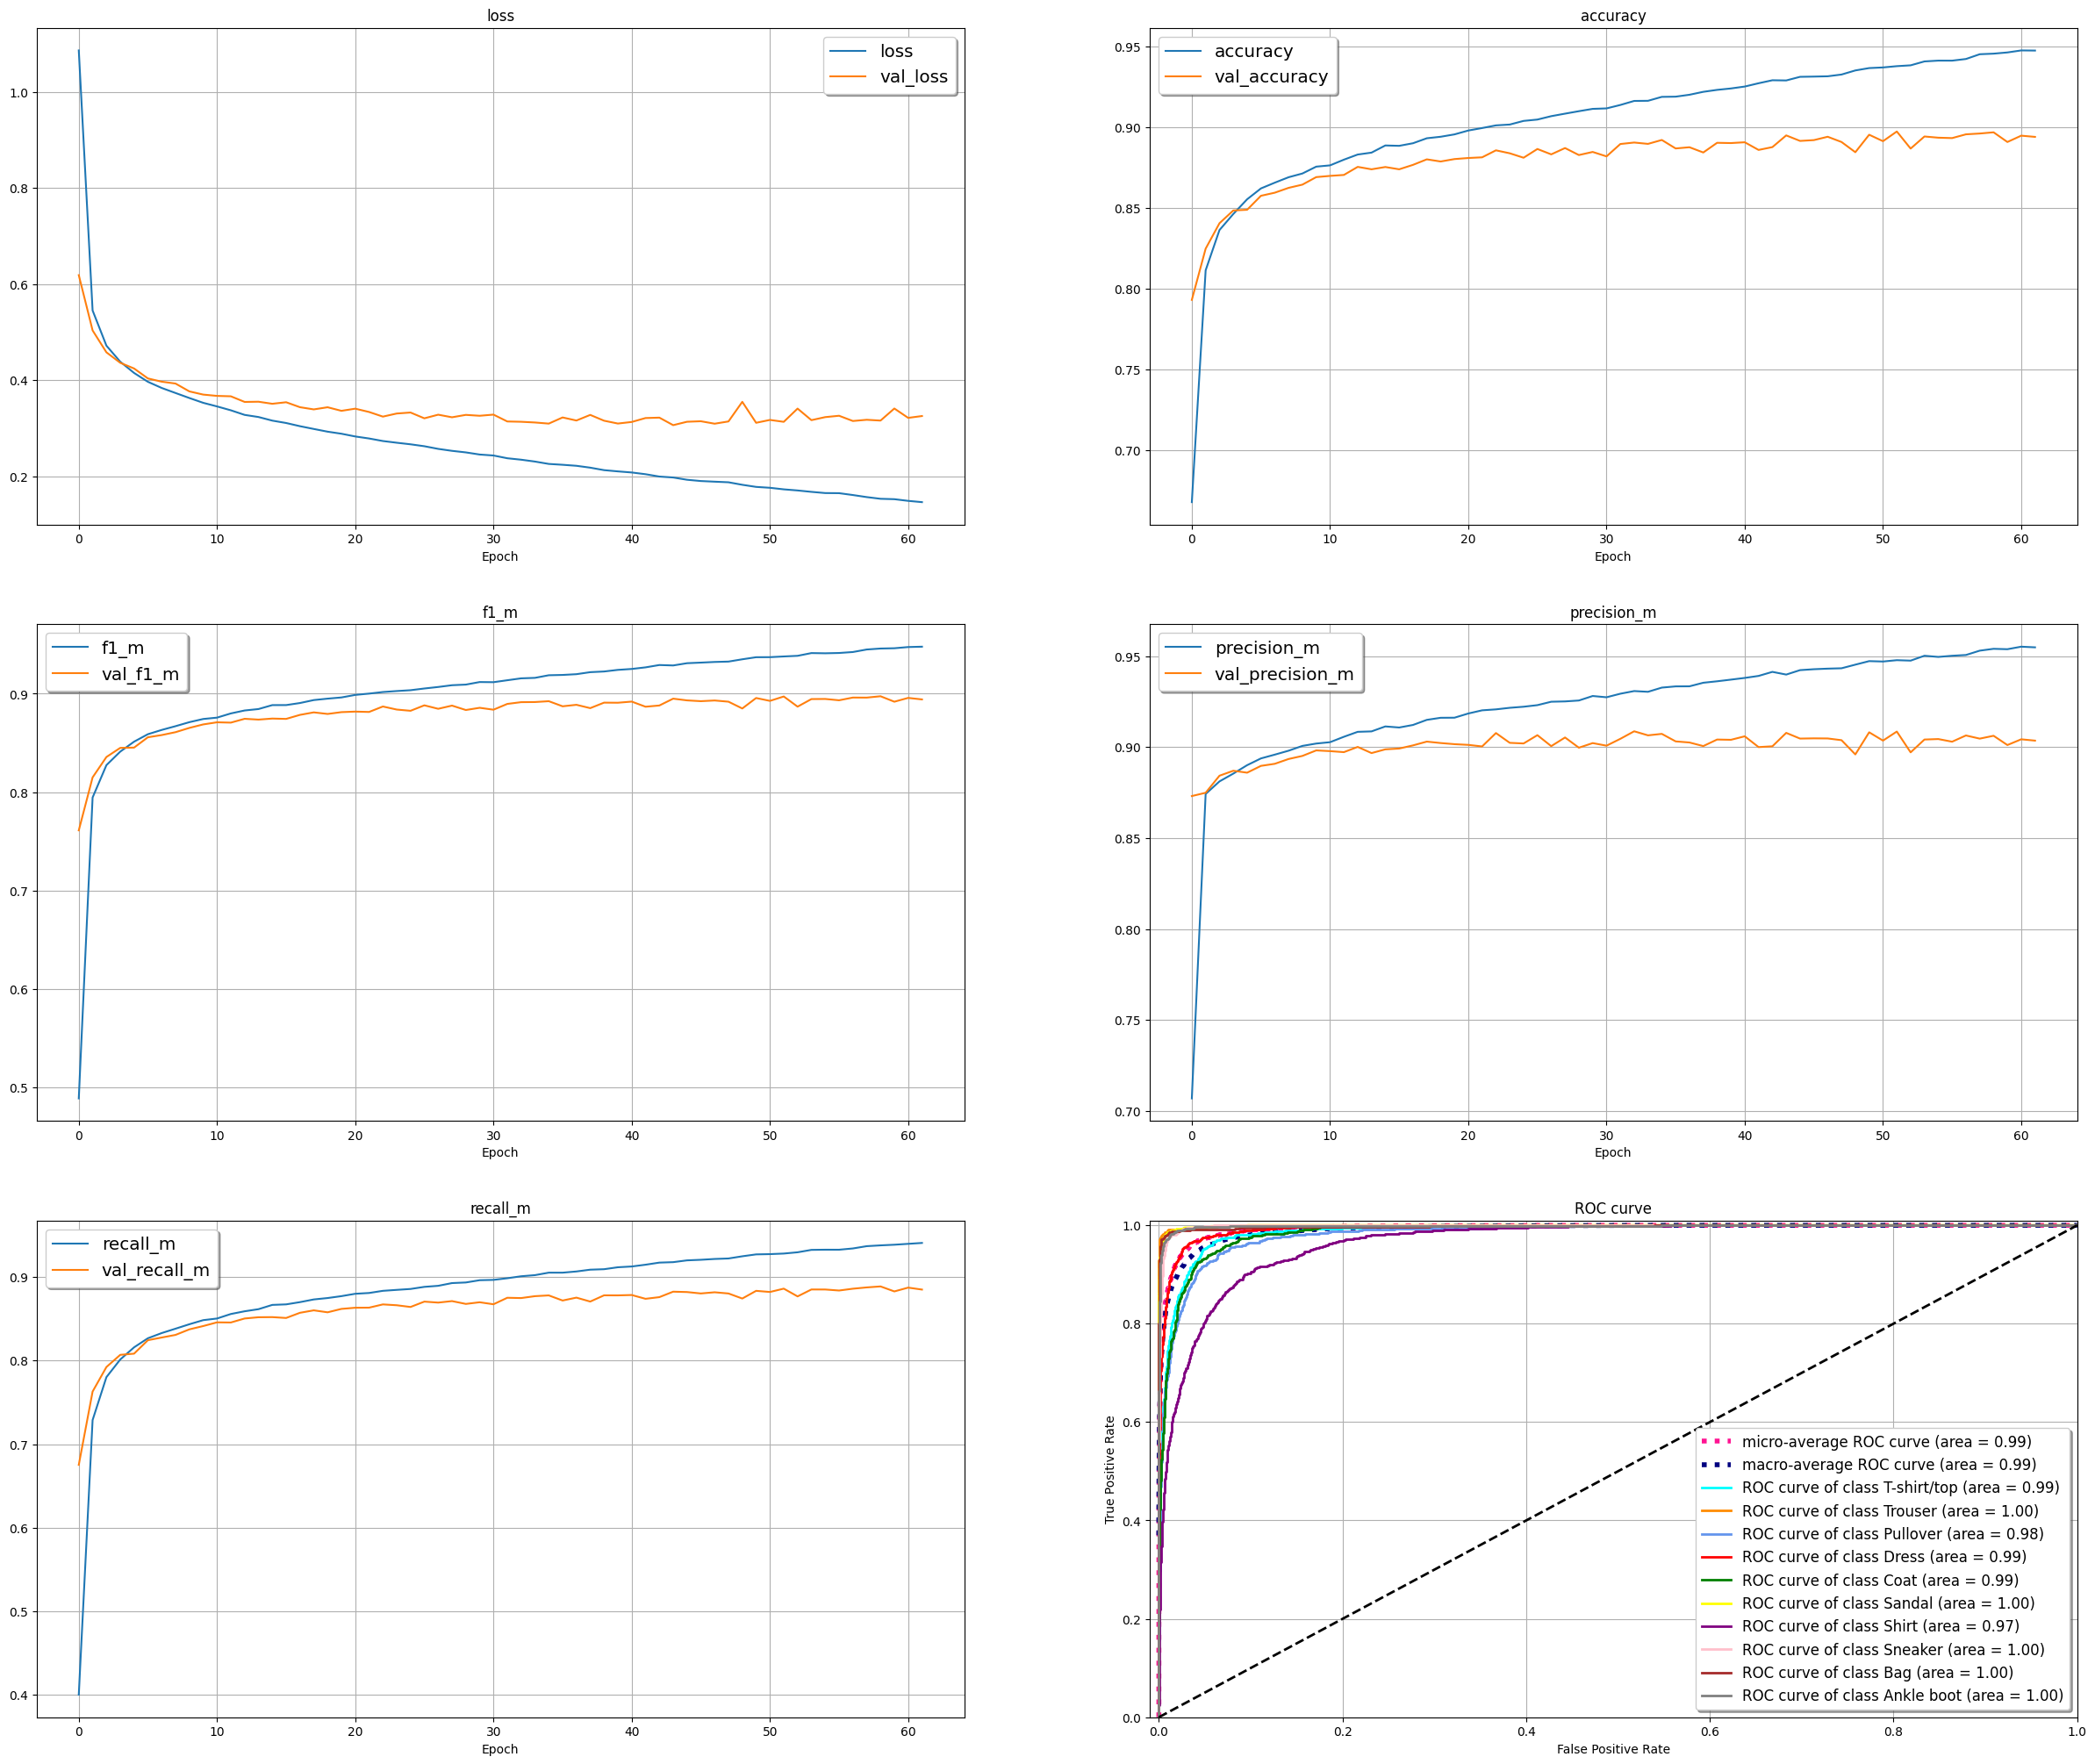

In [41]:
y_pred= model_3_hidden.predict(x_test)

# Print the evaluation metrics
print("MLP 3 hidden layers:")
print("  Accuracy:", model_trained_3.history['val_accuracy'][-1])
print("  Loss:", model_trained_3.history['val_loss'][-1])
print("  Precision:", model_trained_3.history['val_precision_m'][-1])
print("  Recall:", model_trained_3.history['val_recall_m'][-1])
print("  F1-score:", model_trained_3.history['val_f1_m'][-1])
print("  ROC AUC:", roc_auc_score(y_sparse_test, y_pred, multi_class='ovr', average="macro"))


metrics = [[['loss', "loss"],['val_loss',"val_loss"]],
            [['accuracy', "accuracy"],['val_accuracy', "val_accuracy"]],
            [['f1_m', "f1_m"],['val_f1_m', "val_f1_m"]],
            [['precision_m', "precision_m"],['val_precision_m', "val_precision_m"]],
            [['recall_m', "recall_m"],['val_recall_m', "val_recall_m"]],
            [['', ""],['', ""]]]

f, axis = plt.subplots(3, 2, figsize=(30, 25))
k = 0
for i in range(3):
    for j in range(2):
        if(k < 5):
            axis[i,j].plot(model_trained_3.history[metrics[k][0][0]], label = metrics[k][0][1])
            axis[i,j].plot(model_trained_3.history[metrics[k][1][0]], label = metrics[k][1][1])
            axis[i,j].grid()
            axis[i,j].set_xlabel('Epoch')
            axis[i,j].legend(shadow=True, fontsize='x-large')
            axis[i,j].set_title(metrics[k][0][1])
        else:
            lw=2
            fpr, tpr, roc_auc = hp.plot_ROC(y_sparse_test, y_pred, class_names)
            axis[i,j].plot(fpr["micro"], tpr["micro"],
                        label='micro-average ROC curve (area = {0:0.2f})'
                            ''.format(roc_auc["micro"]),
                        color='deeppink', linestyle=':', linewidth=4)

            axis[i,j].plot(fpr["macro"], tpr["macro"],
                        label='macro-average ROC curve (area = {0:0.2f})'
                            ''.format(roc_auc["macro"]),
                        color='navy', linestyle=':', linewidth=4)

            colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'yellow', 'purple', 'pink', 'brown', 'gray'])
            for h, color in zip(range(len(class_names)), colors):
                axis[i,j].plot(fpr[h], tpr[h], color=color, lw=lw,
                            label='ROC curve of class {0} (area = {1:0.2f})'
                            ''.format(class_names[h], roc_auc[h]))

            axis[i,j].plot([0, 1], [0, 1], 'k--', lw=lw)
            axis[i,j].set_xlim([-0.01, 1.0])
            axis[i,j].set_ylim([0.0, 1.01])
            axis[i,j].set_xlabel('False Positive Rate')
            axis[i,j].set_ylabel('True Positive Rate')
            axis[i,j].set_title('ROC curve')
            axis[i,j].grid()
            axis[i,j].legend(loc="lower right", shadow=True, fontsize='large')
        k += 1



We achieved a slightly better accuracy. Let's keep this model, check the best parameters and look for the way to reduce the overfitting.

### Optimizers: we will keep Adam as the optimazer as we check with the softmax.


### Learning rate


In [43]:

learning_rate = [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]

accuracies_lr = []
losses_lr = []
histories_lr = []
for lr in learning_rate:
    K.clear_session()
    model_lr = hp.classification_model(     x_train.shape,
                                    output_size = 10,
                                    hidden_layers_size = 3,
                                    hidden_layers_units = [512, 128, 64],
                                    hidden_activation = 'relu',
                                    kernel_initializer= 'random_normal',
                                    dropout_rate = [0.0, 0.0, 0.0],
                                    regularizer = None,
                                    regularizer_rate = 0.001,
                                    bias_initializer = 'zeros',
                                    use_batch_normalization=[False, False, False],
                                    lr = lr,
                                    decay = 0,
                                    out_softmax = True,
                                    optimizer = Adam)
    model_trained_lr = model_lr.fit(    x_train,
                                  y_sparse_train,
                                  epochs=512, batch_size=128,
                                  verbose=0,
                                  validation_data = (x_val, y_val_categorical),
                                  callbacks=[hp.callback_EarlyStopping()],
                                )
    accuracies_lr.append(model_trained_lr.history['val_accuracy'])
    losses_lr.append(model_trained_lr.history['val_loss'])
    histories_lr.append(model_trained_lr.history)

Epoch 35: early stopping
Epoch 33: early stopping
Epoch 41: early stopping
Epoch 31: early stopping
Epoch 63: early stopping
Epoch 117: early stopping


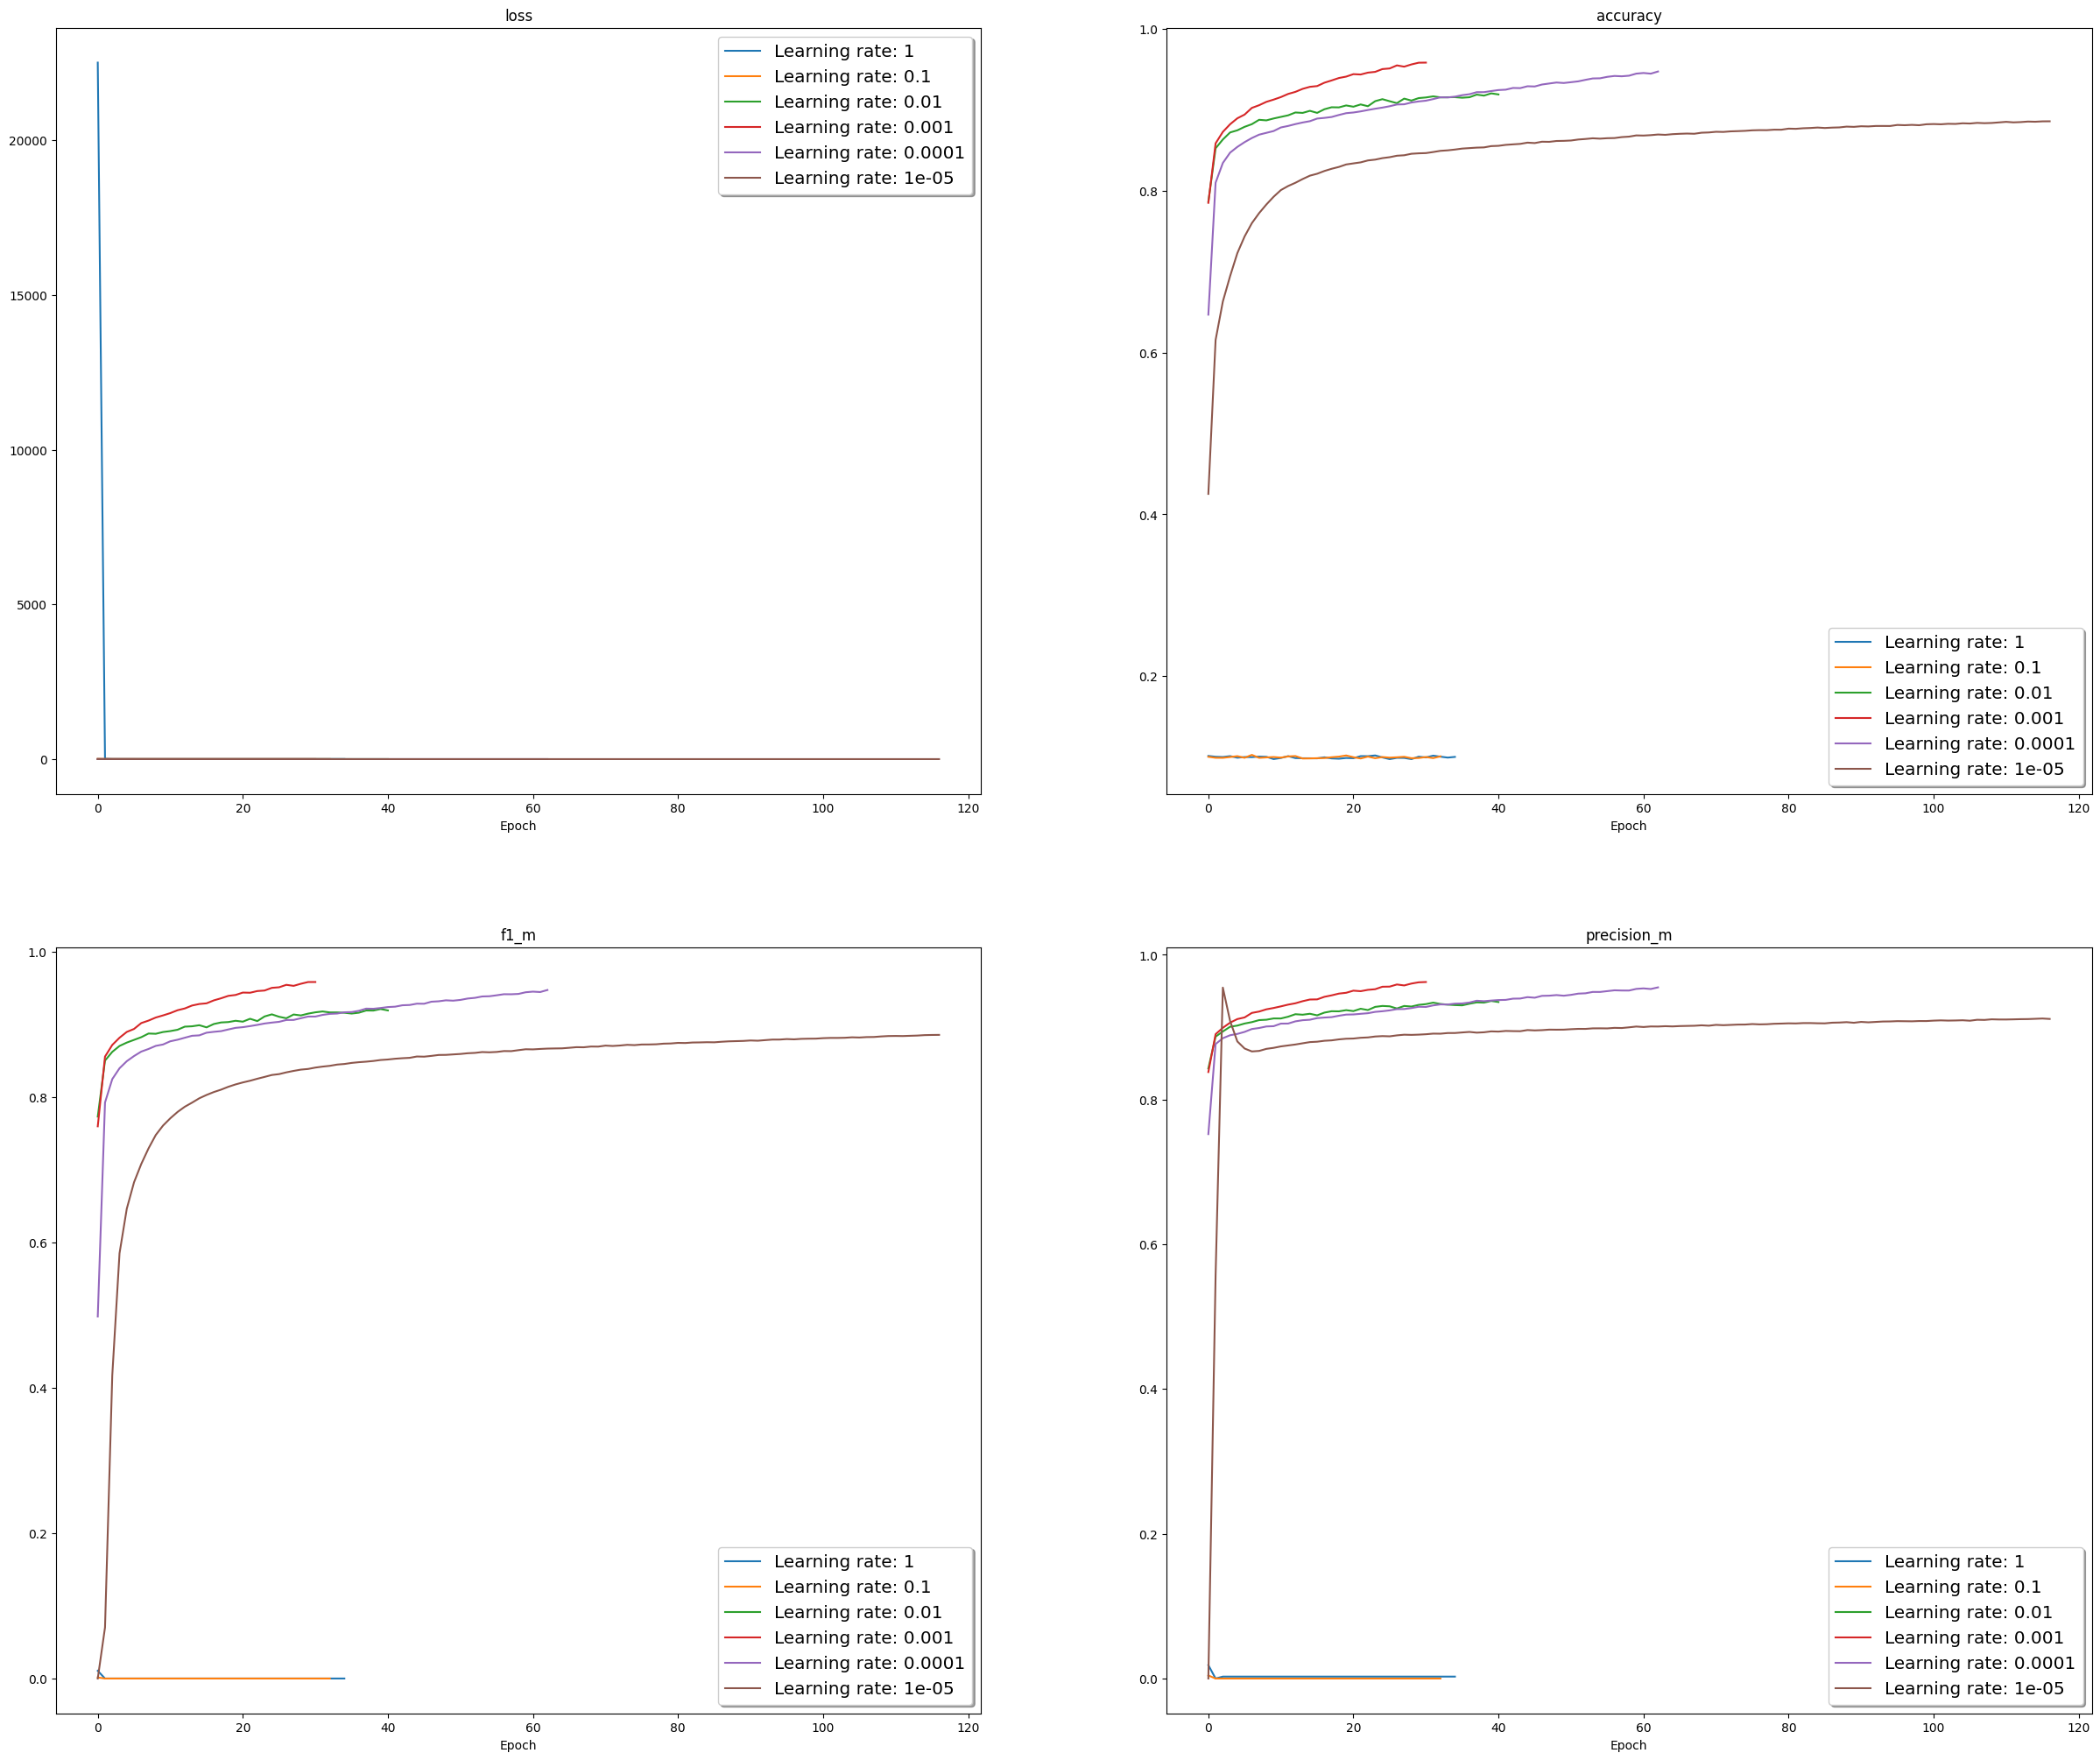

In [44]:
f, axis = plt.subplots(2, 2, figsize=(30, 25))
k = 0
for i in range(2):
    for j in range(2):
      for lr in range(len(learning_rate)):
        axis[i,j].plot(histories_lr[lr][metrics[k][0][0]], label=f'Learning rate: {learning_rate[lr]}')
        axis[i,j].grid()
        axis[i,j].set_xlabel('Epoch')
        axis[i,j].legend(shadow=True, fontsize='x-large')
        axis[i,j].set_title(metrics[k][0][1])
      k += 1
plt.show()


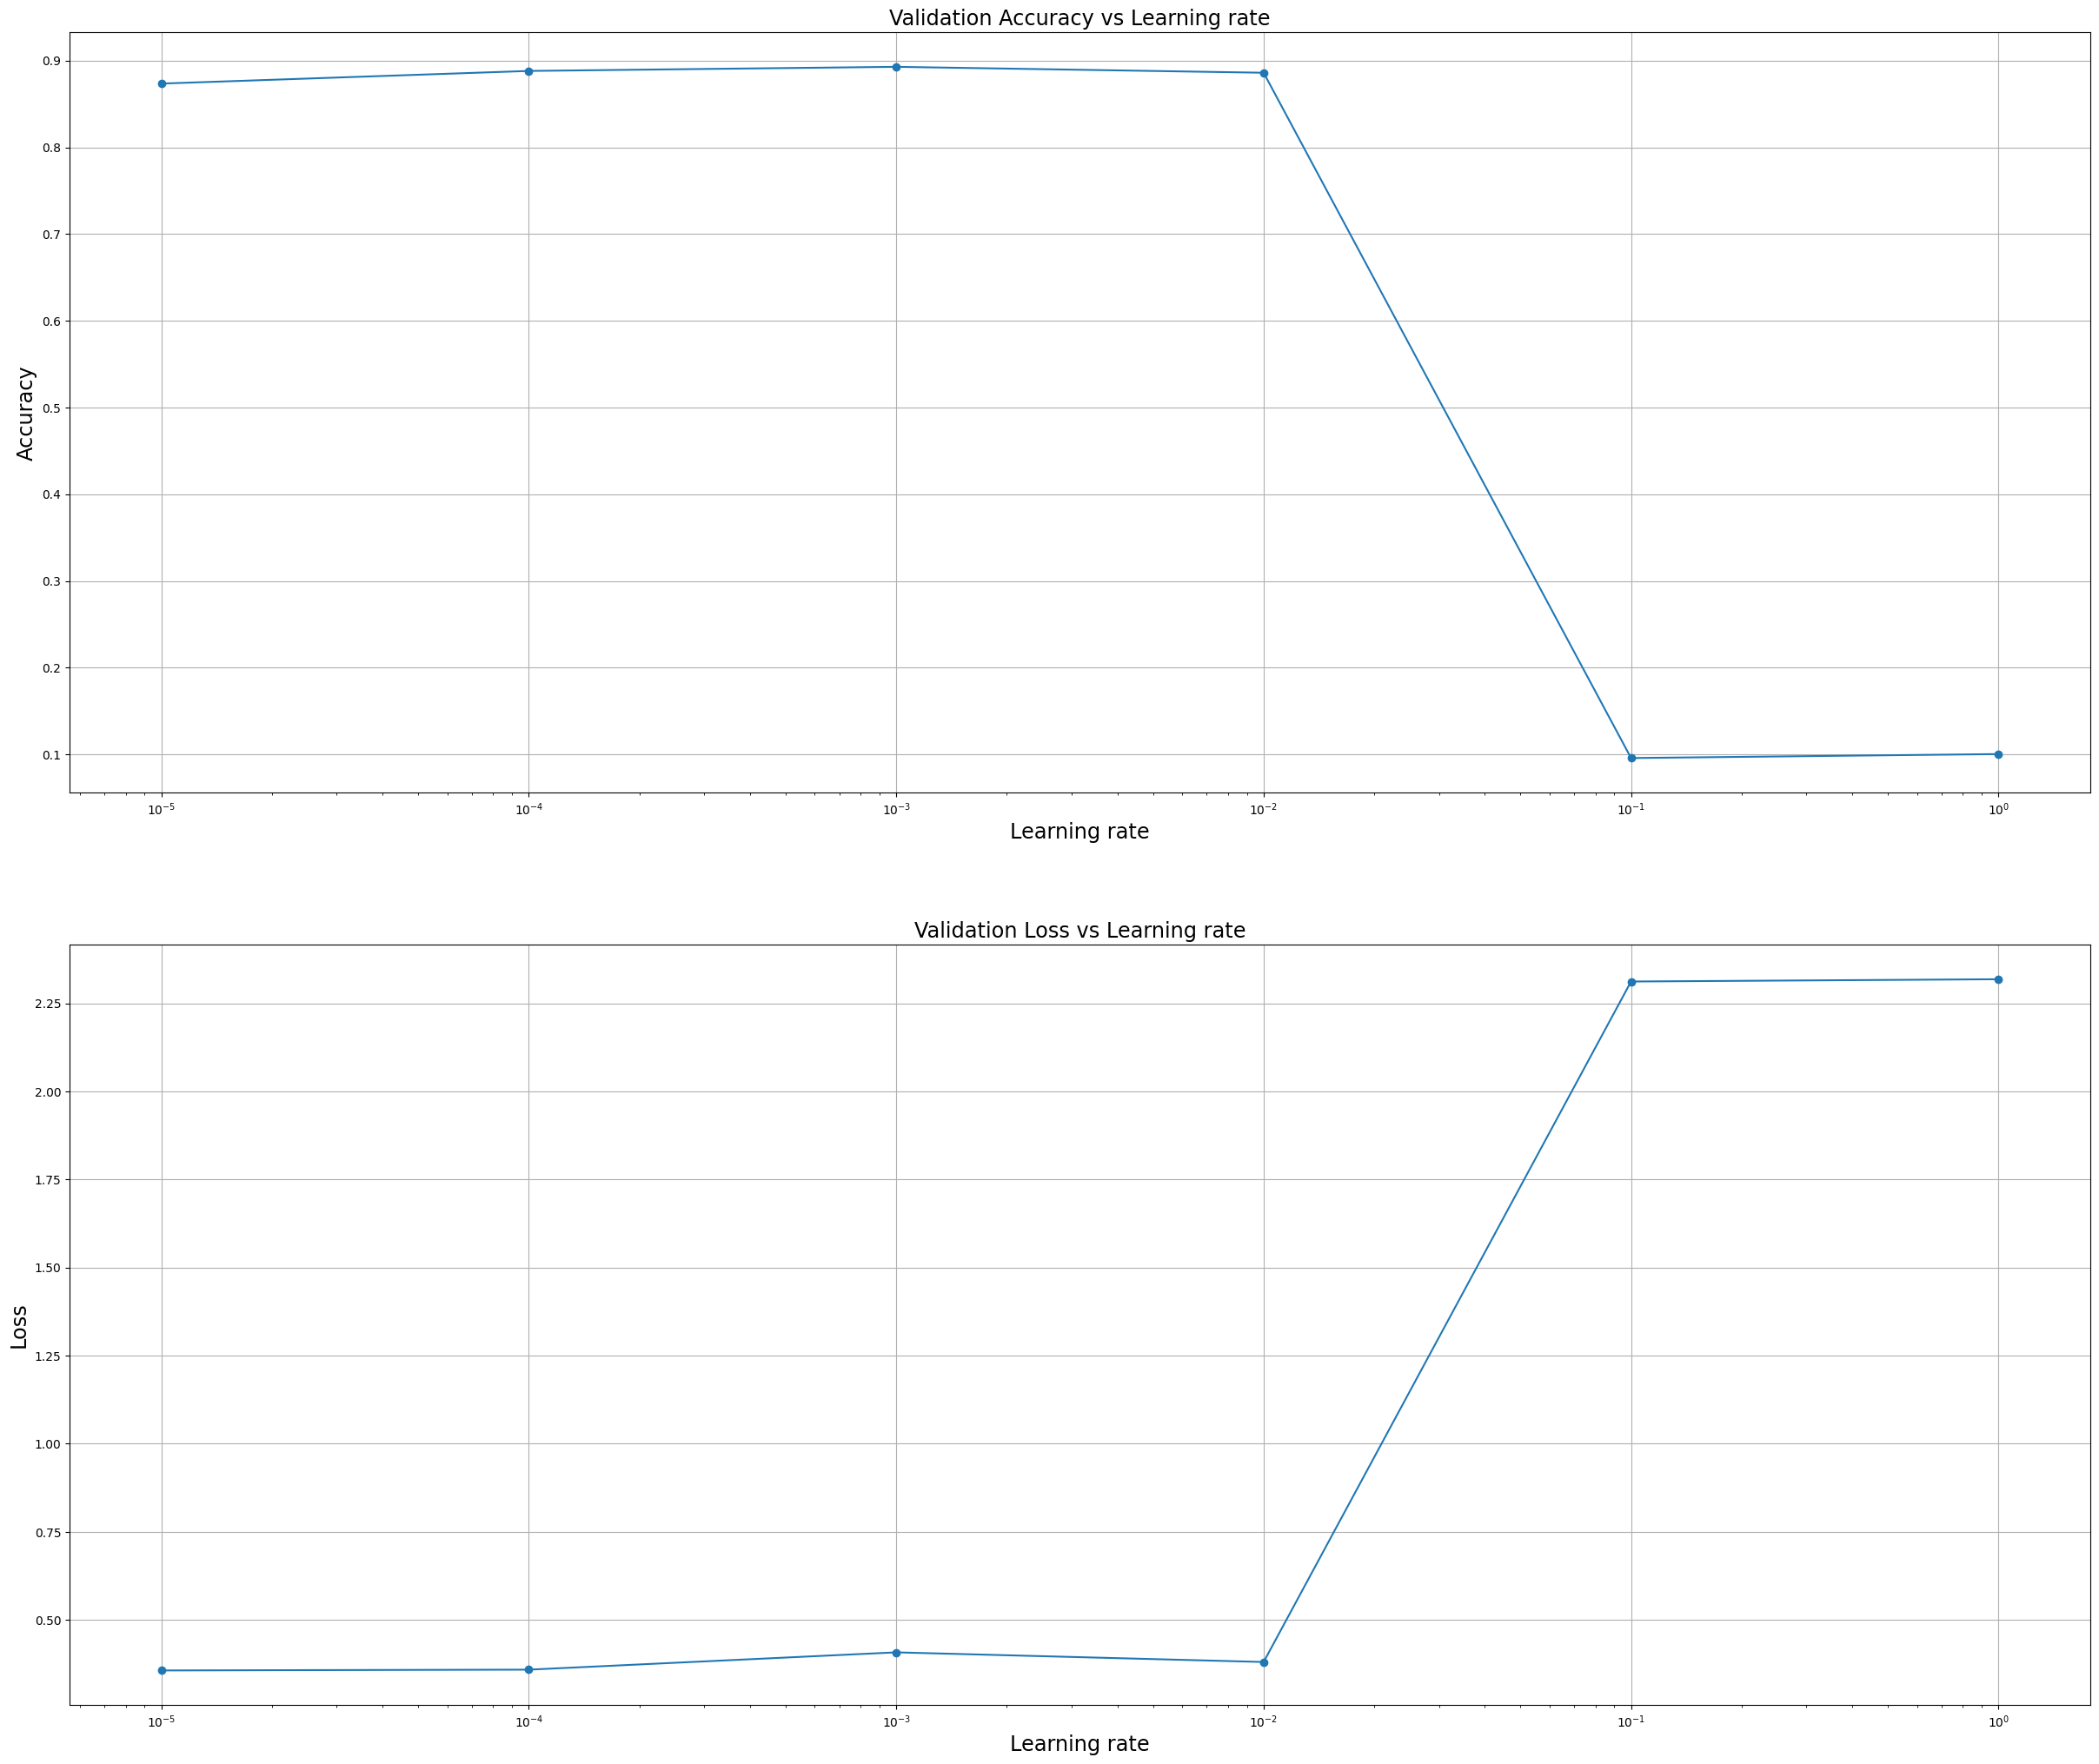

In [45]:
final_accuracies = [acc[-1] for acc in accuracies_lr]
final_losses = [loss[-1] for loss in losses_lr]

# Plotting accuracies
f, axis = plt.subplots(2, 1, figsize=(30, 25))
axis[0].plot(learning_rate, final_accuracies, marker = 'o')
axis[0].set_xlabel('Learning rate', fontsize='xx-large')
axis[0].set_ylabel('Accuracy', fontsize='xx-large')
axis[0].set_title('Validation Accuracy vs Learning rate', fontsize='xx-large')
axis[0].set_xscale('log')
axis[0].grid()

# Plotting losses
axis[1].plot(learning_rate, final_losses, marker = 'o')
axis[1].set_xlabel('Learning rate', fontsize='xx-large')
axis[1].set_ylabel('Loss', fontsize='xx-large')
axis[1].set_title('Validation Loss vs Learning rate', fontsize='xx-large')
axis[1].set_xscale('log')
axis[1].grid()

plt.show()

We can see how convergence gets tougher when the learning path is smaller, as it takes so much time, as well as when the learning path is too big as it may oscilate around the local minimum.

As the first learning rates are so similar, we can use a bigger learning rate such as 0.001.

It certeinly was not a good idea to train the model with such a small learning rate... good time to make a tea!

### Batch size

In [46]:
batch_size = [1024, 512, 256, 128, 64, 32]

accuracies_bs = []
losses_bs = []
histories_bs = []
for bs in batch_size:
    K.clear_session()
    model_bs = hp.classification_model(     x_train.shape,
                                    output_size = 10,
                                    hidden_layers_size = 3,
                                    hidden_layers_units = [512, 128, 64],
                                    hidden_activation = 'relu',
                                    kernel_initializer= 'random_normal',
                                    dropout_rate = [0.0, 0.0, 0.0],
                                    regularizer = None,
                                    regularizer_rate = 0.001,
                                    bias_initializer = 'zeros',
                                    use_batch_normalization=[False, False, False],
                                    lr = 0.001,
                                    decay = 0,
                                    out_softmax = True,
                                    optimizer = Adam)
    model_trained_bs = model_bs.fit(    x_train,
                                  y_sparse_train,
                                  epochs=512, batch_size=bs,
                                  verbose=0,
                                  validation_data = (x_val, y_val_categorical),
                                  callbacks=[hp.callback_EarlyStopping()],
                                )
    accuracies_bs.append(model_trained_bs.history['val_accuracy'])
    losses_bs.append(model_trained_bs.history['val_loss'])
    histories_bs.append(model_trained_bs.history)


Epoch 86: early stopping
Epoch 73: early stopping
Epoch 64: early stopping
Epoch 48: early stopping
Epoch 44: early stopping
Epoch 53: early stopping


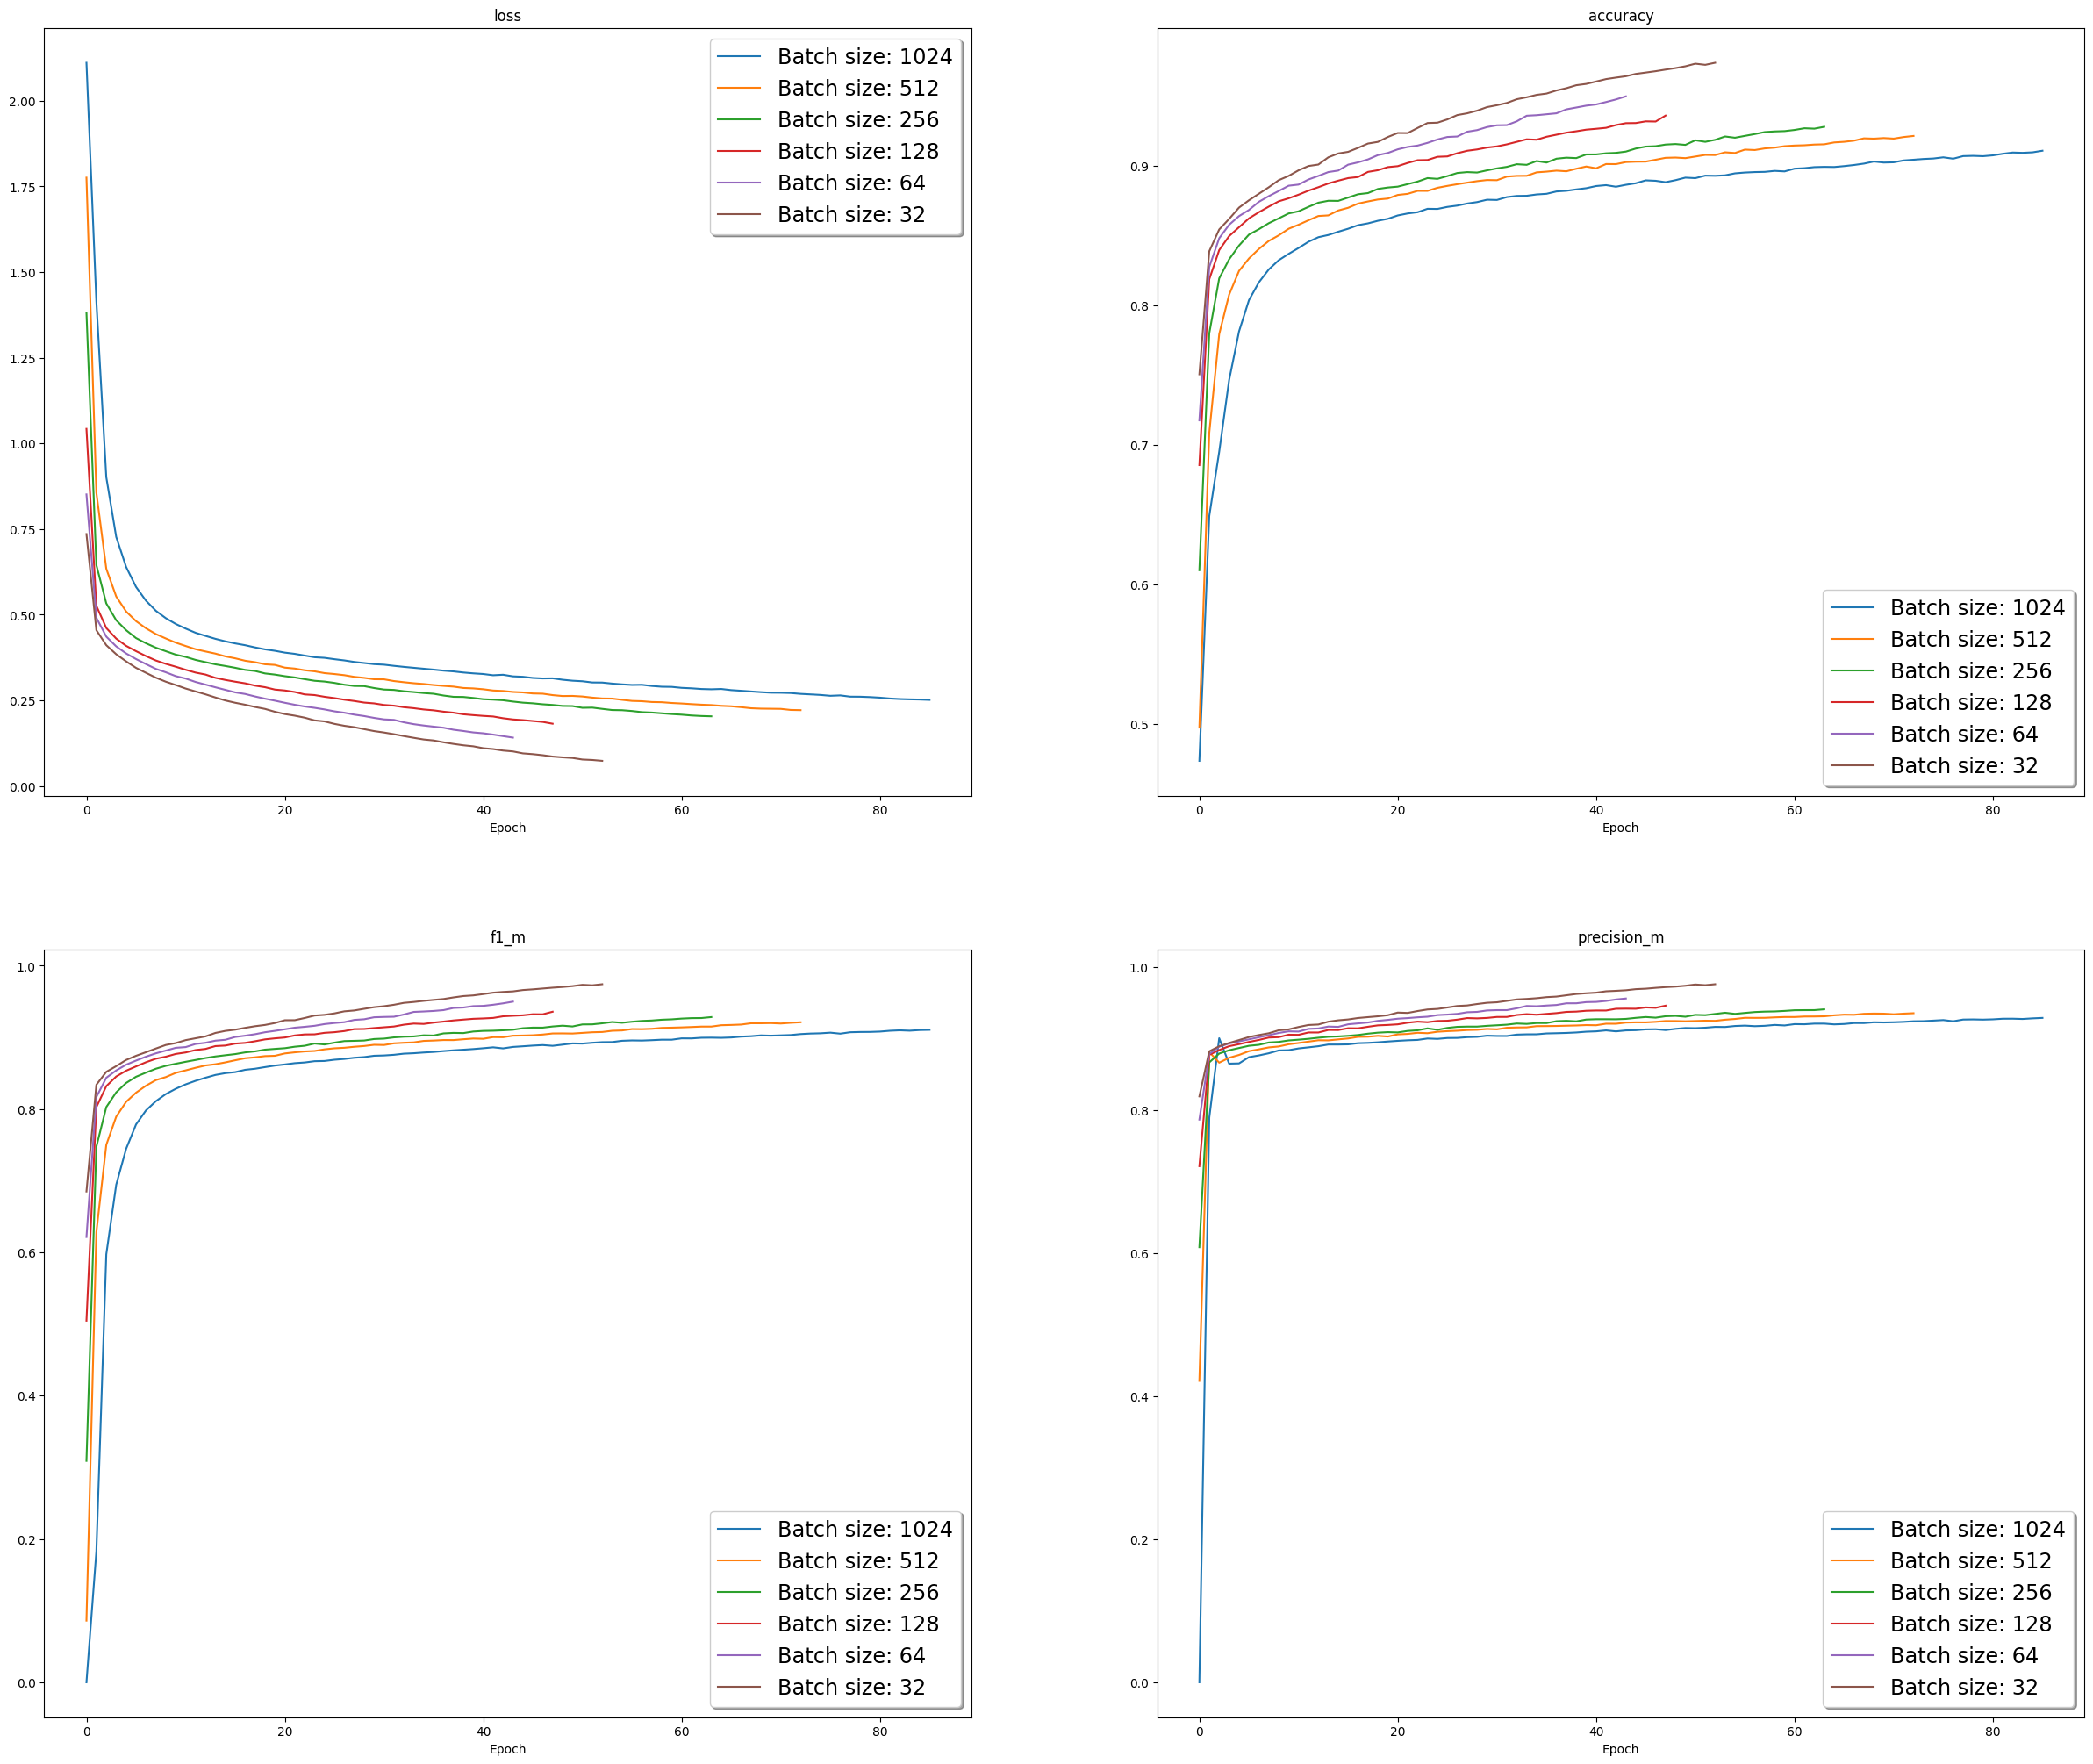

In [47]:
f, axis = plt.subplots(2, 2, figsize=(30, 25))
k = 0
for i in range(2):
    for j in range(2):
      for bs in range(len(batch_size)):
        axis[i,j].plot(histories_bs[bs][metrics[k][0][0]], label=f'Batch size: {batch_size[bs]}')
        axis[i,j].grid()
        axis[i,j].set_xlabel('Epoch')
        axis[i,j].legend(shadow=True, fontsize='xx-large')
        axis[i,j].set_title(metrics[k][0][1])
      k += 1
plt.show()



Batch size:  1024  --- accuracy:  0.8865833282470703  --- loss:  0.3229672610759735
Batch size:  512  --- accuracy:  0.8880000114440918  --- loss:  0.31880441308021545
Batch size:  256  --- accuracy:  0.890916645526886  --- loss:  0.3136565387248993
Batch size:  128  --- accuracy:  0.890666663646698  --- loss:  0.32116463780403137
Batch size:  64  --- accuracy:  0.8918333053588867  --- loss:  0.35066837072372437
Batch size:  32  --- accuracy:  0.8929166793823242  --- loss:  0.4237658977508545


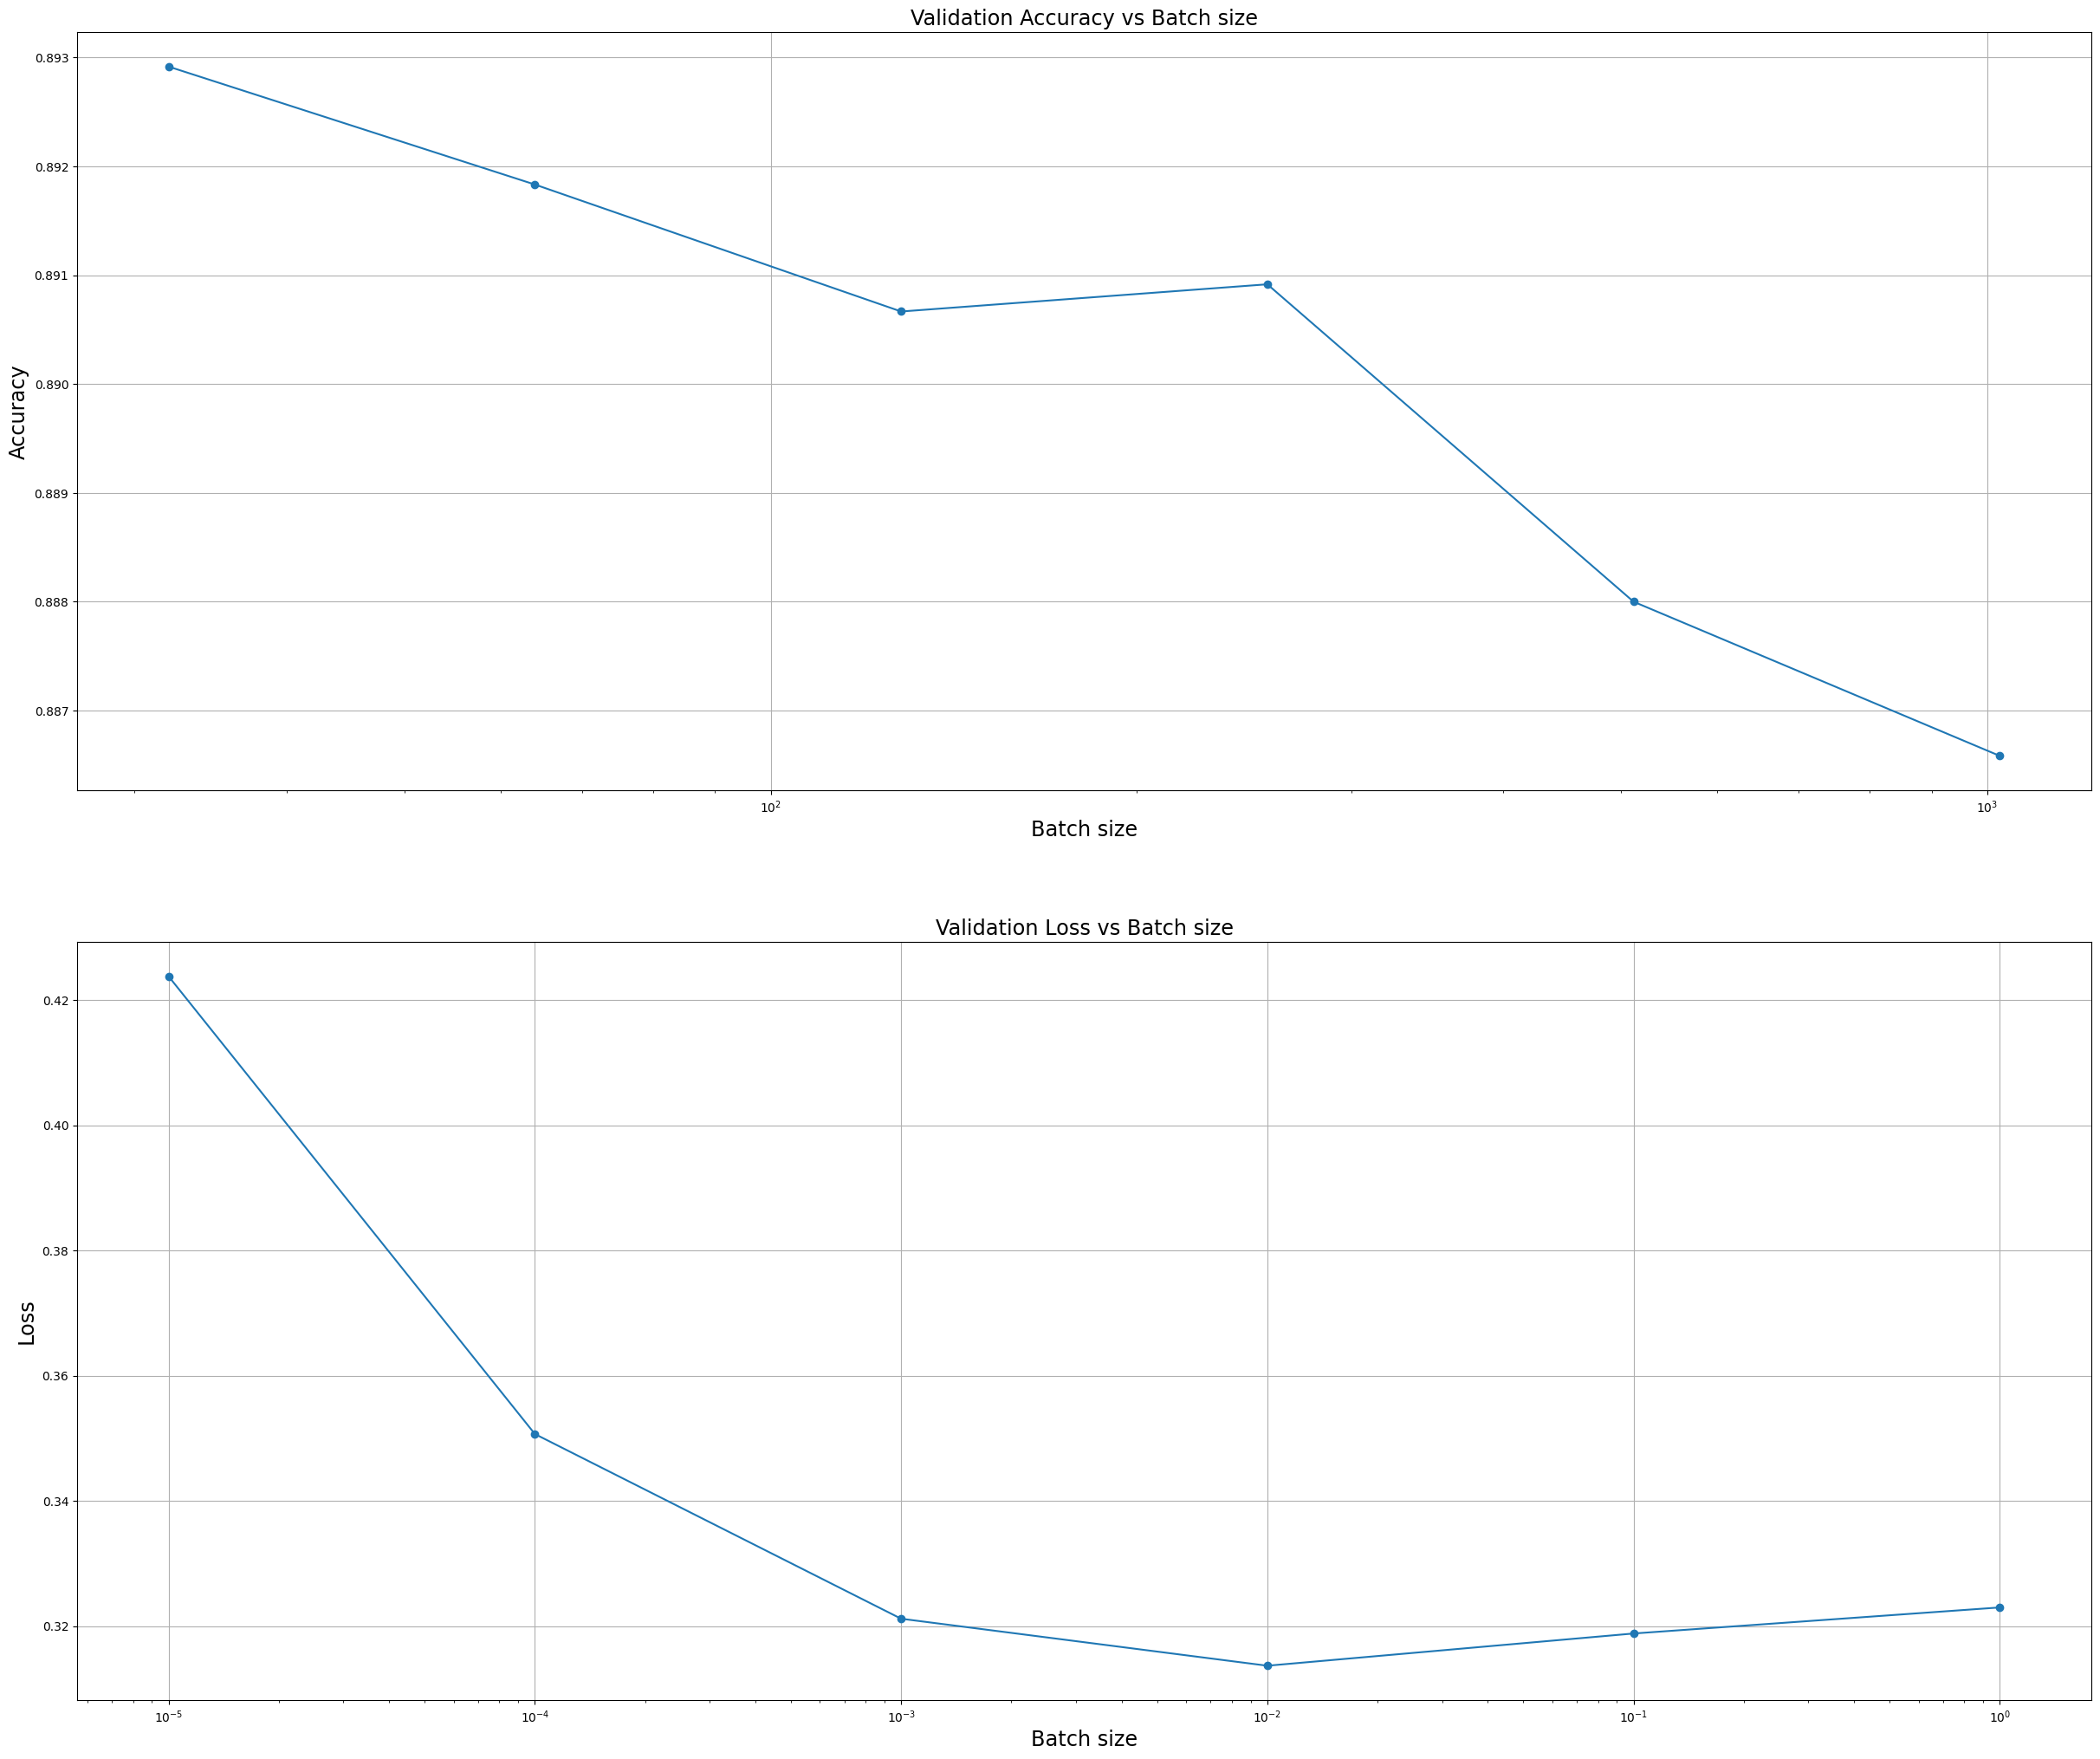

In [49]:
final_accuracies = [acc[-1] for acc in accuracies_bs]
final_losses = [loss[-1] for loss in losses_bs]

for i in range(len(batch_size)):
  print("Batch size: ", batch_size[i] ," --- accuracy: ", final_accuracies[i], " --- loss: ", final_losses[i])

# Plotting accuracies
f, axis = plt.subplots(2, 1, figsize=(30, 25))
axis[0].plot(batch_size, final_accuracies, marker = 'o')
axis[0].set_xlabel('Batch size', fontsize='xx-large')
axis[0].set_ylabel('Accuracy', fontsize='xx-large')
axis[0].set_title('Validation Accuracy vs Batch size', fontsize='xx-large')
axis[0].set_xscale('log')
axis[0].grid()

# Plotting losses
axis[1].plot(learning_rate, final_losses, marker = 'o')
axis[1].set_xlabel('Batch size', fontsize='xx-large')
axis[1].set_ylabel('Loss', fontsize='xx-large')
axis[1].set_title('Validation Loss vs Batch size', fontsize='xx-large')
axis[1].set_xscale('log')
axis[1].grid()

plt.show()

And here it is quite clear that we get a better accuracy as we reduce the batch size BUT the loss gets worse as well. Let's keep a batch size of 256.

### Dropout rate

In [50]:
dropout_rate = [[0.0, 0.0, 0.0], [0.125, 0.125, 0.125], [0.25, 0.25, 0.25], [0.5, 0.5, 0.5]]

accuracies_dr = []
losses_dr = []
histories_dr = []
for dr in dropout_rate:
    K.clear_session()
    model_dr = hp.classification_model(     x_train.shape,
                                    output_size = 10,
                                    hidden_layers_size = 3,
                                    hidden_layers_units = [512, 128, 64],
                                    hidden_activation = 'relu',
                                    kernel_initializer= 'random_normal',
                                    dropout_rate = dr,
                                    regularizer = None,
                                    regularizer_rate = 0.001,
                                    bias_initializer = 'zeros',
                                    use_batch_normalization=[False, False, False],
                                    lr = 0.001,
                                    decay = 0,
                                    out_softmax = True,
                                    optimizer = Adam)
    model_trained_dr = model_dr.fit(    x_train,
                                  y_sparse_train,
                                  epochs=512, batch_size=256,
                                  verbose=0,
                                  validation_data = (x_val, y_val_categorical),
                                  callbacks=[hp.callback_EarlyStopping()],
                                )
    accuracies_dr.append(model_trained_dr.history['val_accuracy'])
    losses_dr.append(model_trained_dr.history['val_loss'])
    histories_dr.append(model_trained_dr.history)


Epoch 37: early stopping
Epoch 64: early stopping
Epoch 67: early stopping
Epoch 62: early stopping


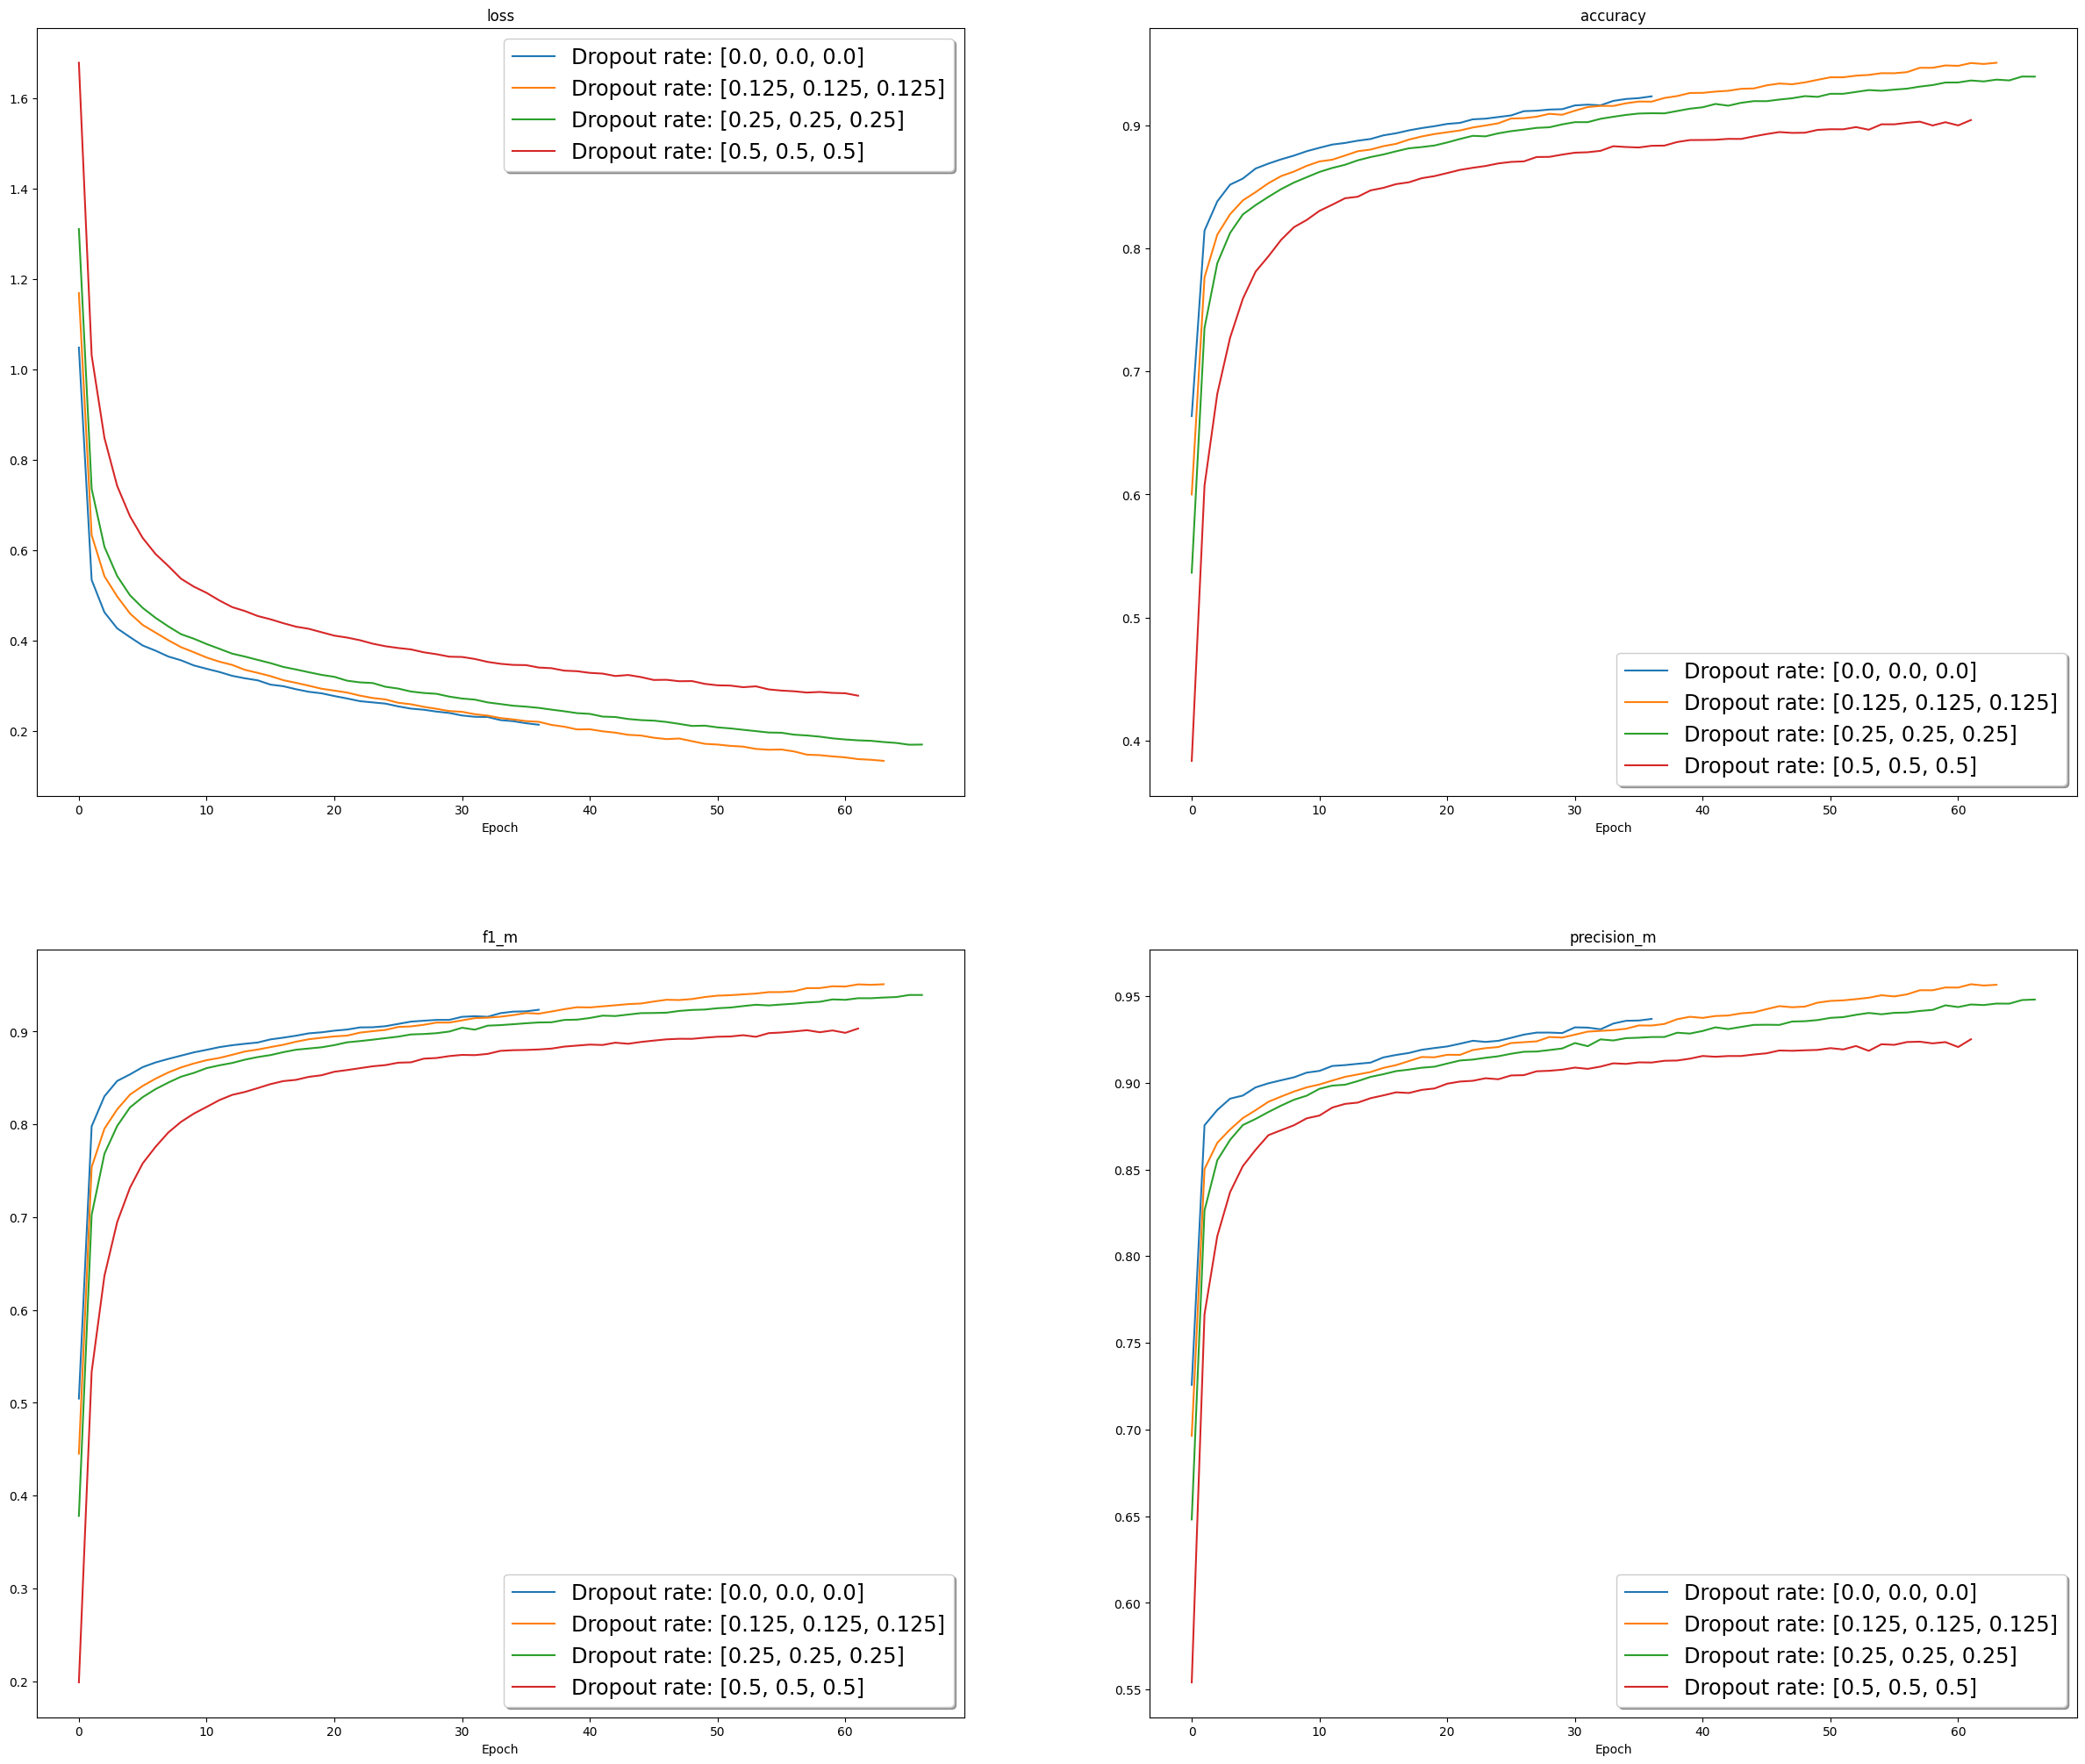

In [51]:
f, axis = plt.subplots(2, 2, figsize=(30, 25))
k = 0
for i in range(2):
    for j in range(2):
      for dr in range(len(dropout_rate)):
        axis[i,j].plot(histories_dr[dr][metrics[k][0][0]], label=f'Dropout rate: {dropout_rate[dr]}')
        axis[i,j].grid()
        axis[i,j].set_xlabel('Epoch')
        axis[i,j].legend(shadow=True, fontsize='xx-large')
        axis[i,j].set_title(metrics[k][0][1])
      k += 1
plt.show()

Dropout rate:  [0.0, 0.0, 0.0]  --- accuracy:  0.8880000114440918  --- loss:  0.3166382312774658
Dropout rate:  [0.125, 0.125, 0.125]  --- accuracy:  0.9003333449363708  --- loss:  0.3247827887535095
Dropout rate:  [0.25, 0.25, 0.25]  --- accuracy:  0.8999999761581421  --- loss:  0.3098343312740326
Dropout rate:  [0.5, 0.5, 0.5]  --- accuracy:  0.8939999938011169  --- loss:  0.311924546957016


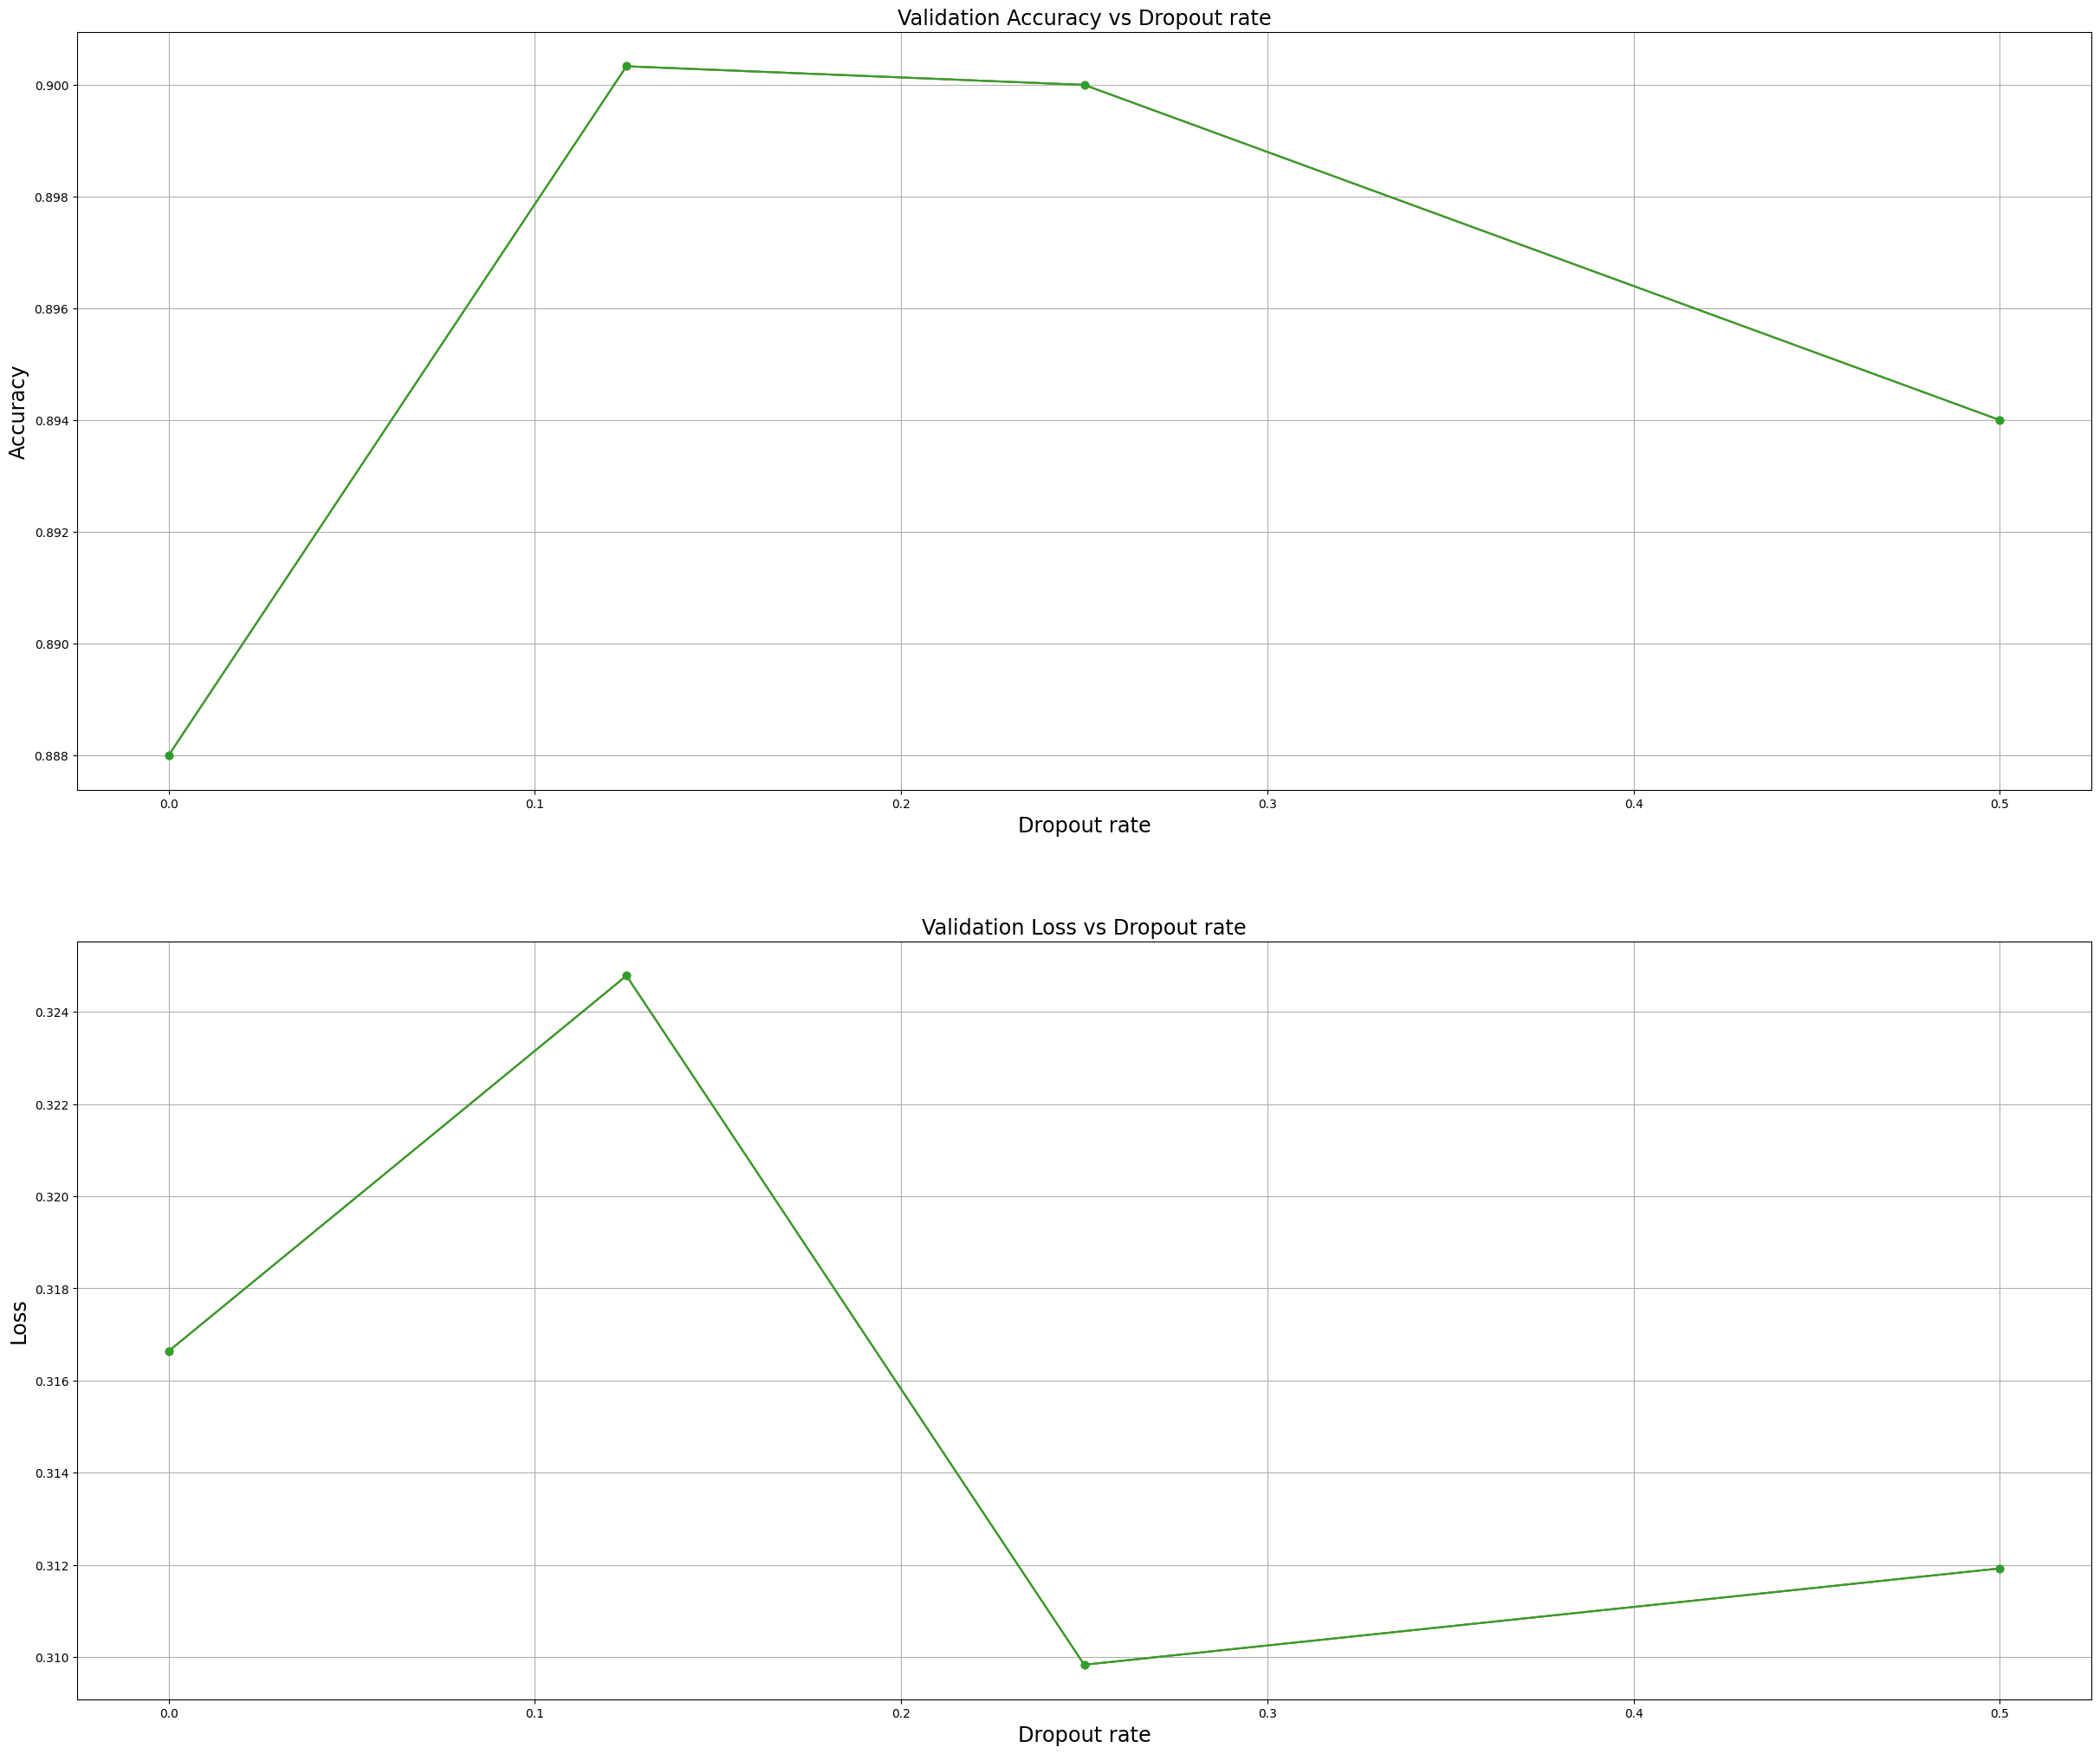

In [54]:
final_accuracies = [acc[-1] for acc in accuracies_dr]
final_losses = [loss[-1] for loss in losses_dr]

for i in range(len(dropout_rate)):
  print("Dropout rate: ", dropout_rate[i] ," --- accuracy: ", final_accuracies[i], " --- loss: ", final_losses[i])

# Plotting accuracies
f, axis = plt.subplots(2, 1, figsize=(30, 25))
axis[0].plot(dropout_rate, final_accuracies, marker = 'o')
axis[0].set_xlabel('Dropout rate', fontsize='xx-large')
axis[0].set_ylabel('Accuracy', fontsize='xx-large')
axis[0].set_title('Validation Accuracy vs Dropout rate', fontsize='xx-large')
#axis[0].set_xscale('log')
axis[0].grid()

# Plotting losses
axis[1].plot(dropout_rate, final_losses, marker = 'o')
axis[1].set_xlabel('Dropout rate', fontsize='xx-large')
axis[1].set_ylabel('Loss', fontsize='xx-large')
axis[1].set_title('Validation Loss vs Dropout rate', fontsize='xx-large')
#axis[1].set_xscale('log')
axis[1].grid()

plt.show()

WOW! It certainly improved with a dropout rate.

### Activation functions

In [56]:
activations = ['relu', 'tanh', 'sigmoid', 'linear']

accuracies_act = []
losses_act = []
histories_act = []
for act in activations:
    K.clear_session()
    model_act = hp.classification_model(    x_train.shape,
                                            output_size = 10,
                                            hidden_layers_size = 3,
                                            hidden_layers_units = [512, 128, 64],
                                            hidden_activation = act,
                                            kernel_initializer= 'random_normal',
                                            dropout_rate = [0.125, 0.125, 0.125],
                                            regularizer = None,
                                            regularizer_rate = 0.001,
                                            bias_initializer = 'zeros',
                                            use_batch_normalization=[False, False, False],
                                            lr = 0.001,
                                            decay = 0,
                                            out_softmax = True,
                                            optimizer = Adam)
    model_trained_act = model_act.fit(    x_train,
                                  y_sparse_train,
                                  epochs=512, batch_size=256,
                                  verbose=0,
                                  validation_data = (x_val, y_val_categorical),
                                  callbacks=[hp.callback_EarlyStopping()],
                                )
    accuracies_act.append(model_trained_act.history['val_accuracy'])
    losses_act.append(model_trained_act.history['val_loss'])
    histories_act.append(model_trained_act.history)


Epoch 36: early stopping
Epoch 33: early stopping
Epoch 52: early stopping
Epoch 39: early stopping


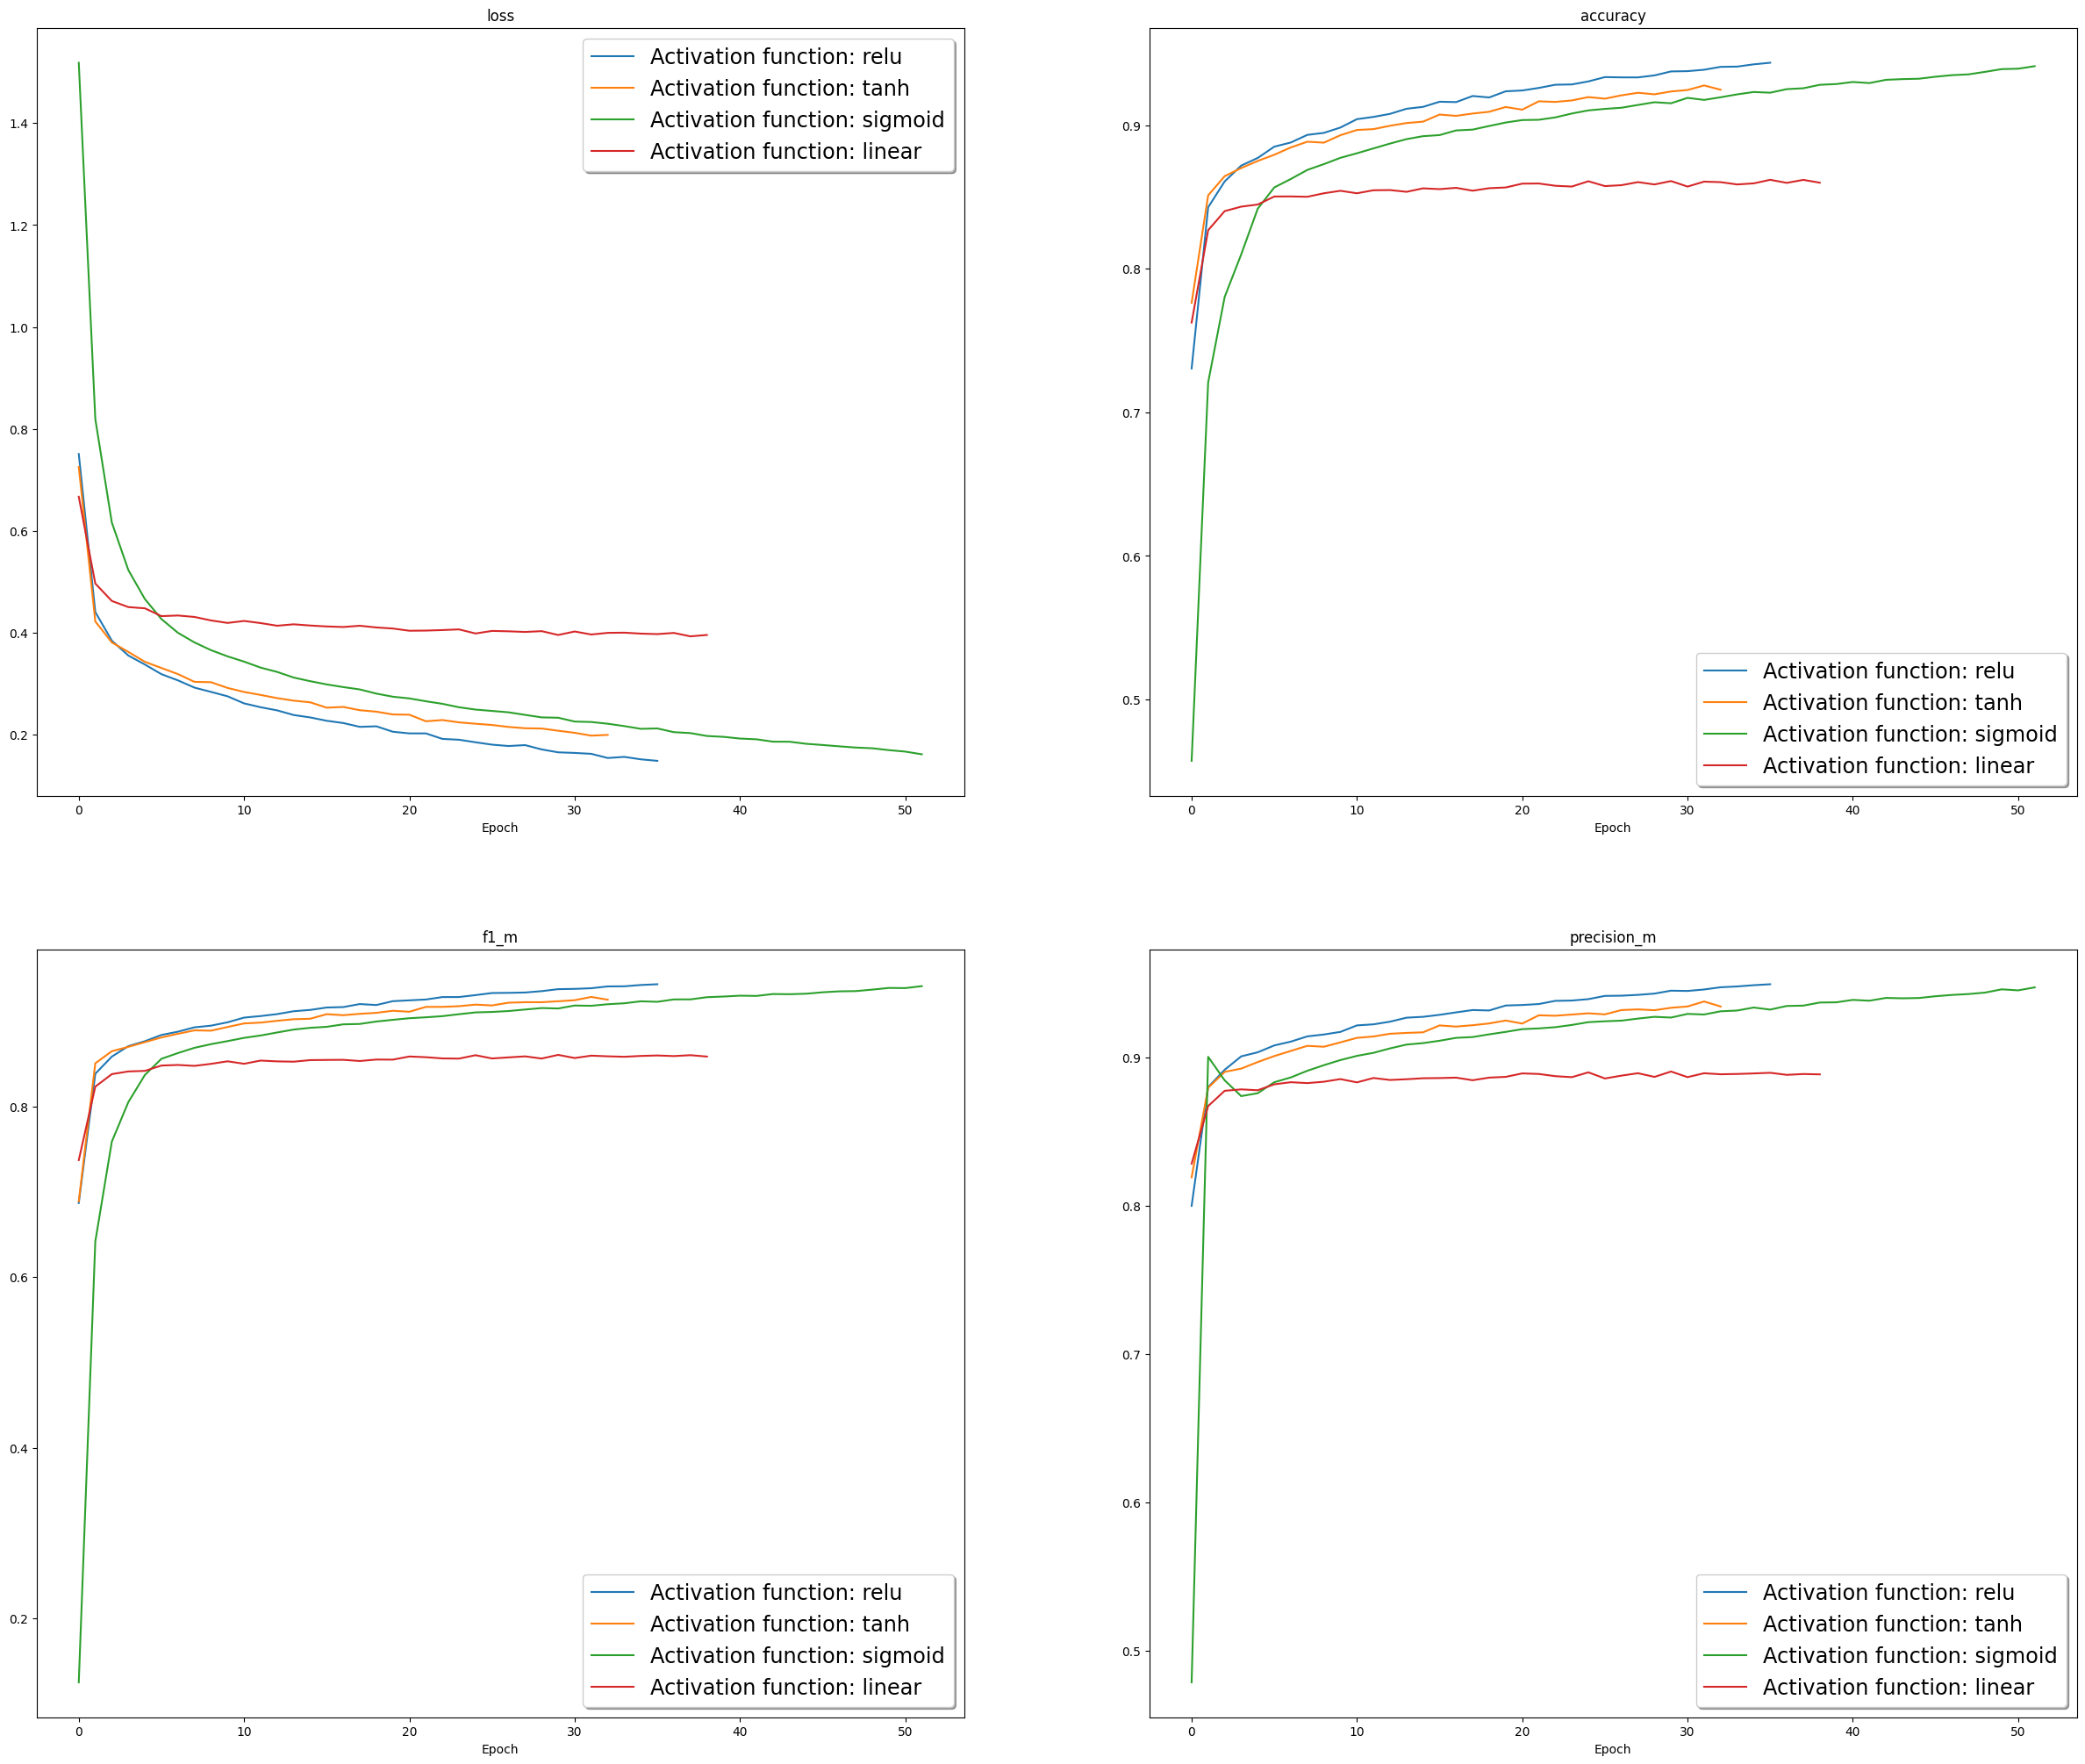

In [57]:
f, axis = plt.subplots(2, 2, figsize=(30, 25))
k = 0
for i in range(2):
    for j in range(2):
      for act in range(len(activations)):
        axis[i,j].plot(histories_act[act][metrics[k][0][0]], label=f'Activation function: {activations[act]}')
        axis[i,j].grid()
        axis[i,j].set_xlabel('Epoch')
        axis[i,j].legend(shadow=True, fontsize='xx-large')
        axis[i,j].set_title(metrics[k][0][1])
      k += 1
plt.show()

Activation Function:  relu  --- accuracy:  0.8974166512489319  --- loss:  0.35272106528282166
Activation Function:  tanh  --- accuracy:  0.8889166712760925  --- loss:  0.3239131569862366
Activation Function:  sigmoid  --- accuracy:  0.8968333601951599  --- loss:  0.3258380591869354
Activation Function:  linear  --- accuracy:  0.8420833349227905  --- loss:  0.4477013647556305


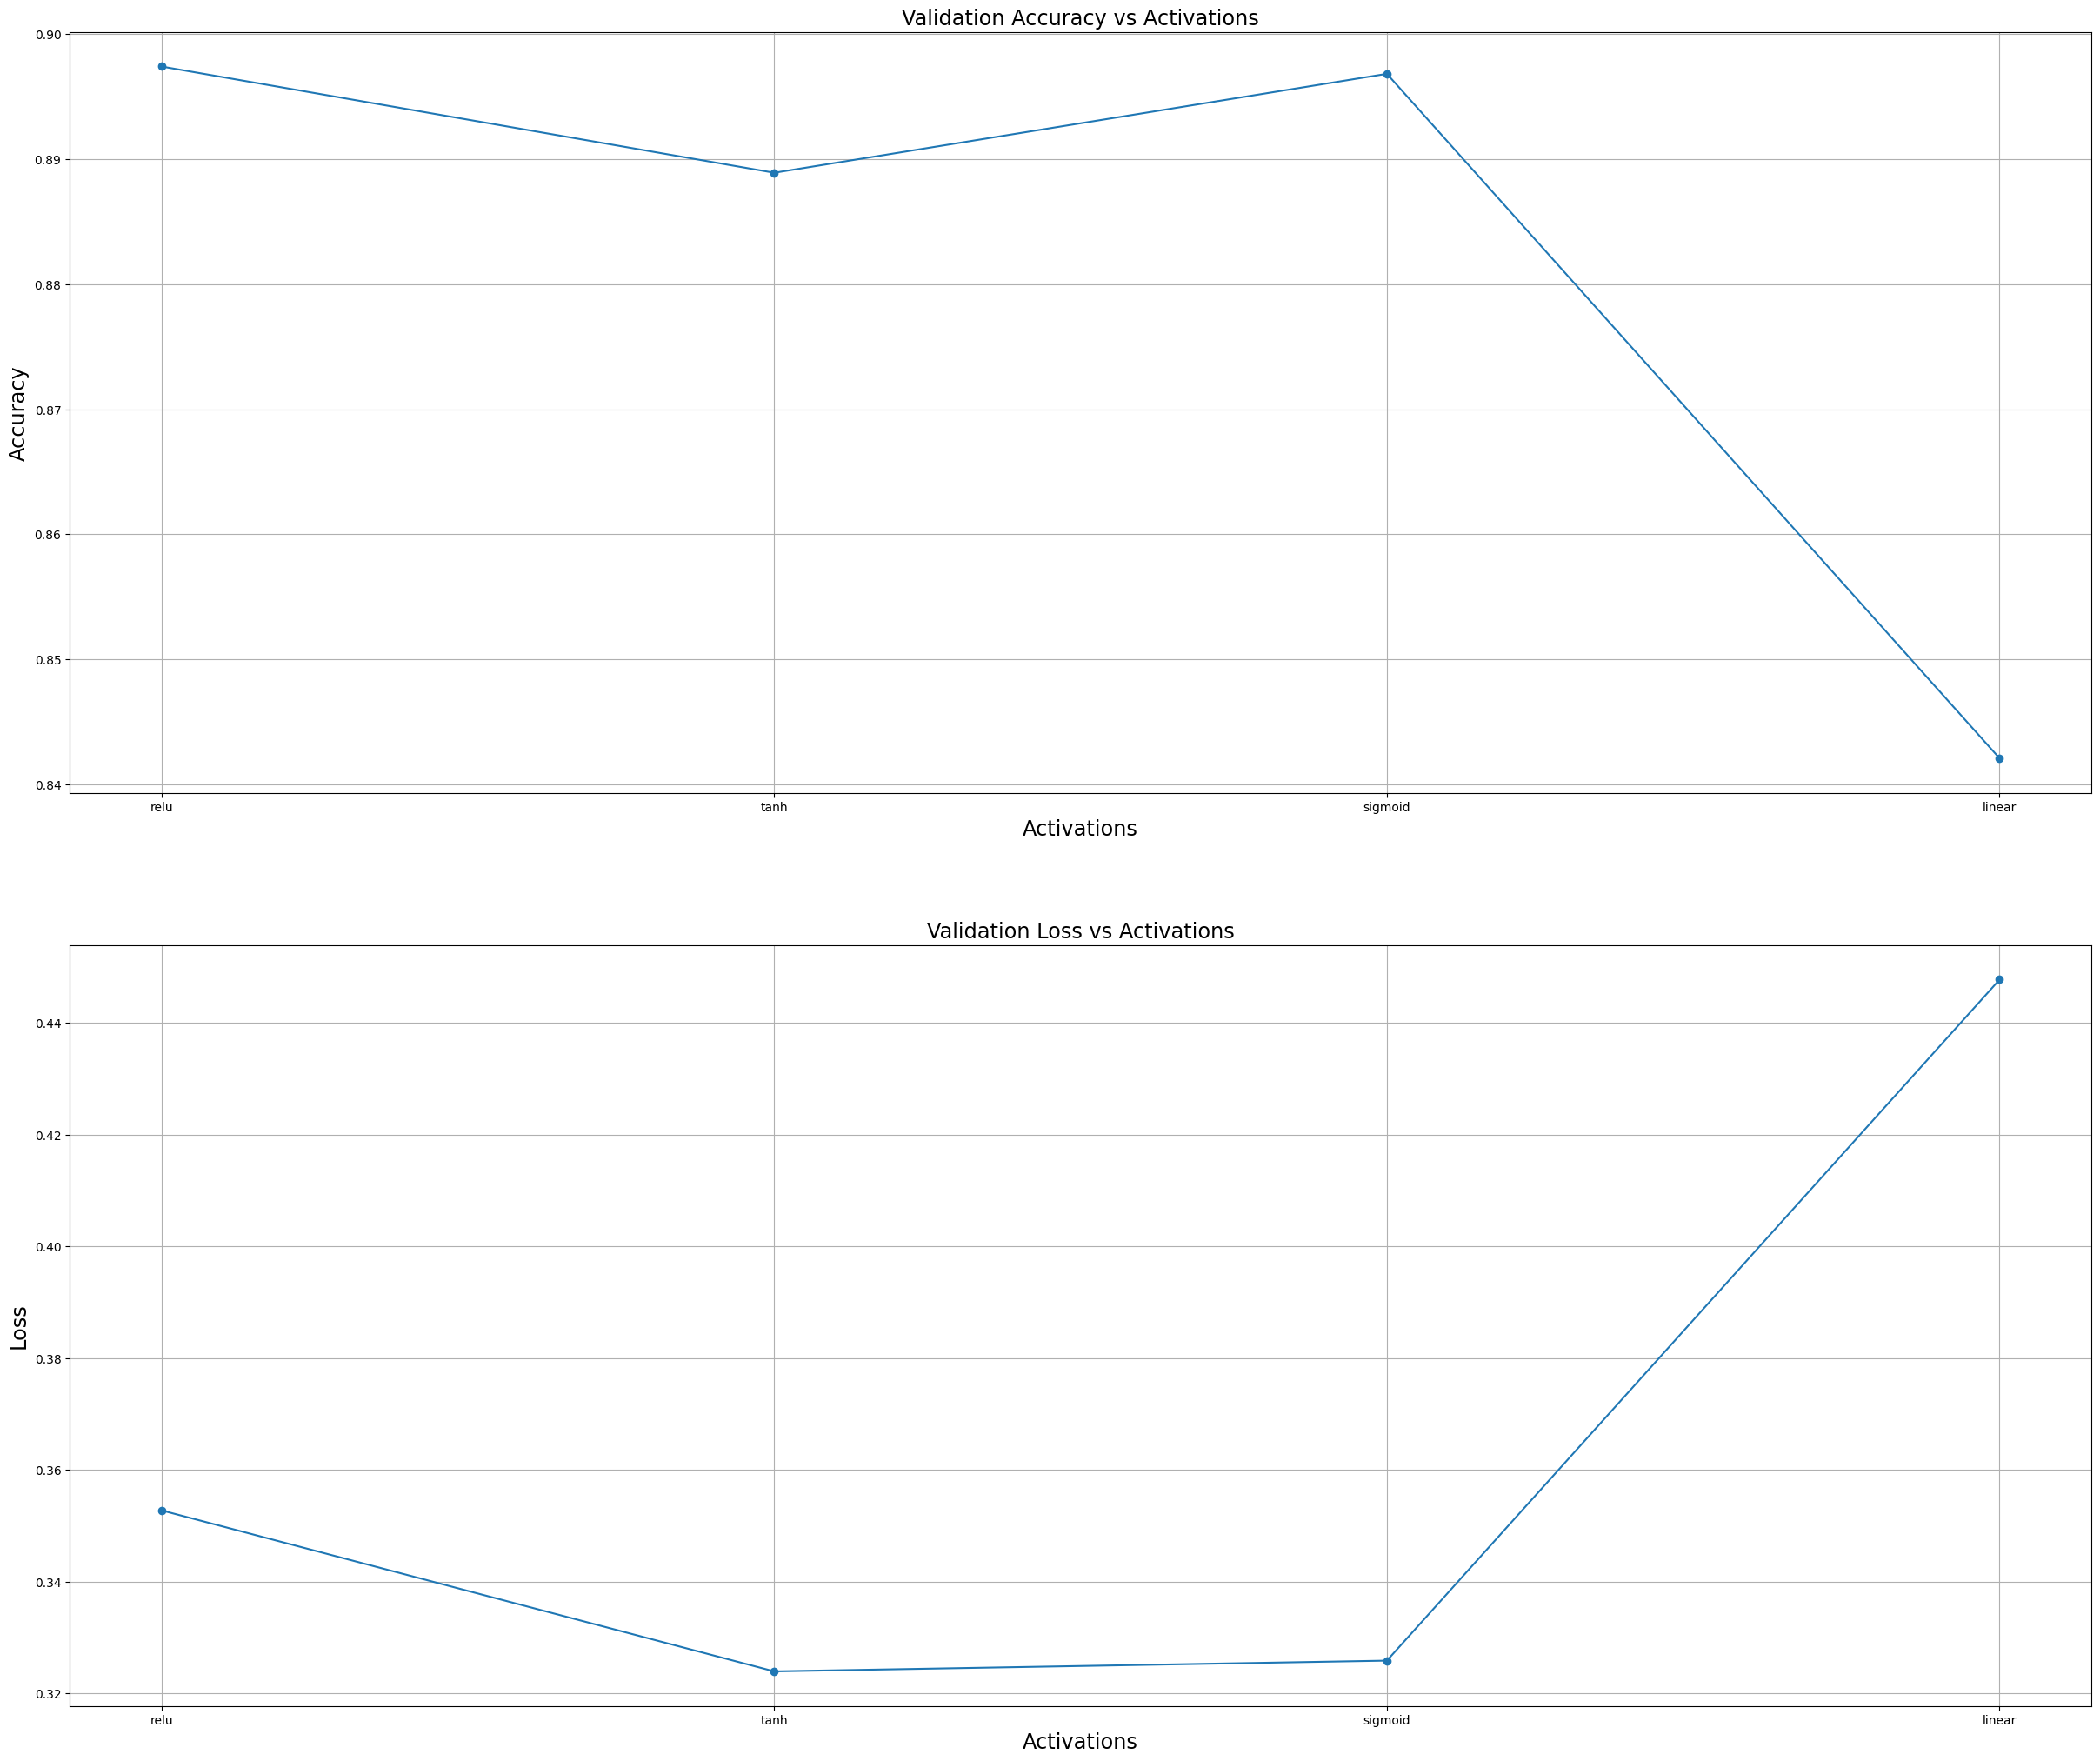

In [58]:
final_accuracies = [acc[-1] for acc in accuracies_act]
final_losses = [loss[-1] for loss in losses_act]

for i in range(len(activations)):
  print("Activation Function: ", activations[i] ," --- accuracy: ", final_accuracies[i], " --- loss: ", final_losses[i])

# Plotting accuracies
f, axis = plt.subplots(2, 1, figsize=(30, 25))
axis[0].plot(activations, final_accuracies, marker = 'o')
axis[0].set_xlabel('Activations', fontsize='xx-large')
axis[0].set_ylabel('Accuracy', fontsize='xx-large')
axis[0].set_title('Validation Accuracy vs Activations', fontsize='xx-large')
#axis[0].set_xscale('log')
axis[0].grid()

# Plotting losses
axis[1].plot(activations, final_losses, marker = 'o')
axis[1].set_xlabel('Activations', fontsize='xx-large')
axis[1].set_ylabel('Loss', fontsize='xx-large')
axis[1].set_title('Validation Loss vs Activations', fontsize='xx-large')
#axis[1].set_xscale('log')
axis[1].grid()

plt.show()

As expected, we get the best results with the Relu activation function.

### Batch normalization

In [62]:
batch_normalization = [[False, False, False], [True, False, False]]

accuracies_bn = []
losses_bn = []
histories_bn = []
for bn in batch_normalization:
    K.clear_session()
    model_bn = hp.classification_model(    x_train.shape,
                                            output_size = 10,
                                            hidden_layers_size = 3,
                                            hidden_layers_units = [512, 128, 64],
                                            hidden_activation = 'relu',
                                            kernel_initializer= 'random_normal',
                                            dropout_rate = [0.125, 0.125, 0.125],
                                            regularizer = None,
                                            regularizer_rate = 0.001,
                                            bias_initializer = 'zeros',
                                            use_batch_normalization=bn,
                                            lr = 0.001,
                                            decay = 0,
                                            out_softmax = True,
                                            optimizer = Adam)
    model_trained_bn = model_bn.fit(    x_train,
                                  y_sparse_train,
                                  epochs=512, batch_size=256,
                                  verbose=0,
                                  validation_data = (x_val, y_val_categorical),
                                  callbacks=[hp.callback_EarlyStopping()],
                                )
    accuracies_bn.append(model_trained_bn.history['val_accuracy'])
    losses_bn.append(model_trained_bn.history['val_loss'])
    histories_bn.append(model_trained_bn.history)


Epoch 33: early stopping
Epoch 52: early stopping


Max accuracy: 0.8949999809265137 at batch normalization = [False, False, False]
Min loss: 0.30063655972480774 at batch normalization = [False, False, False]


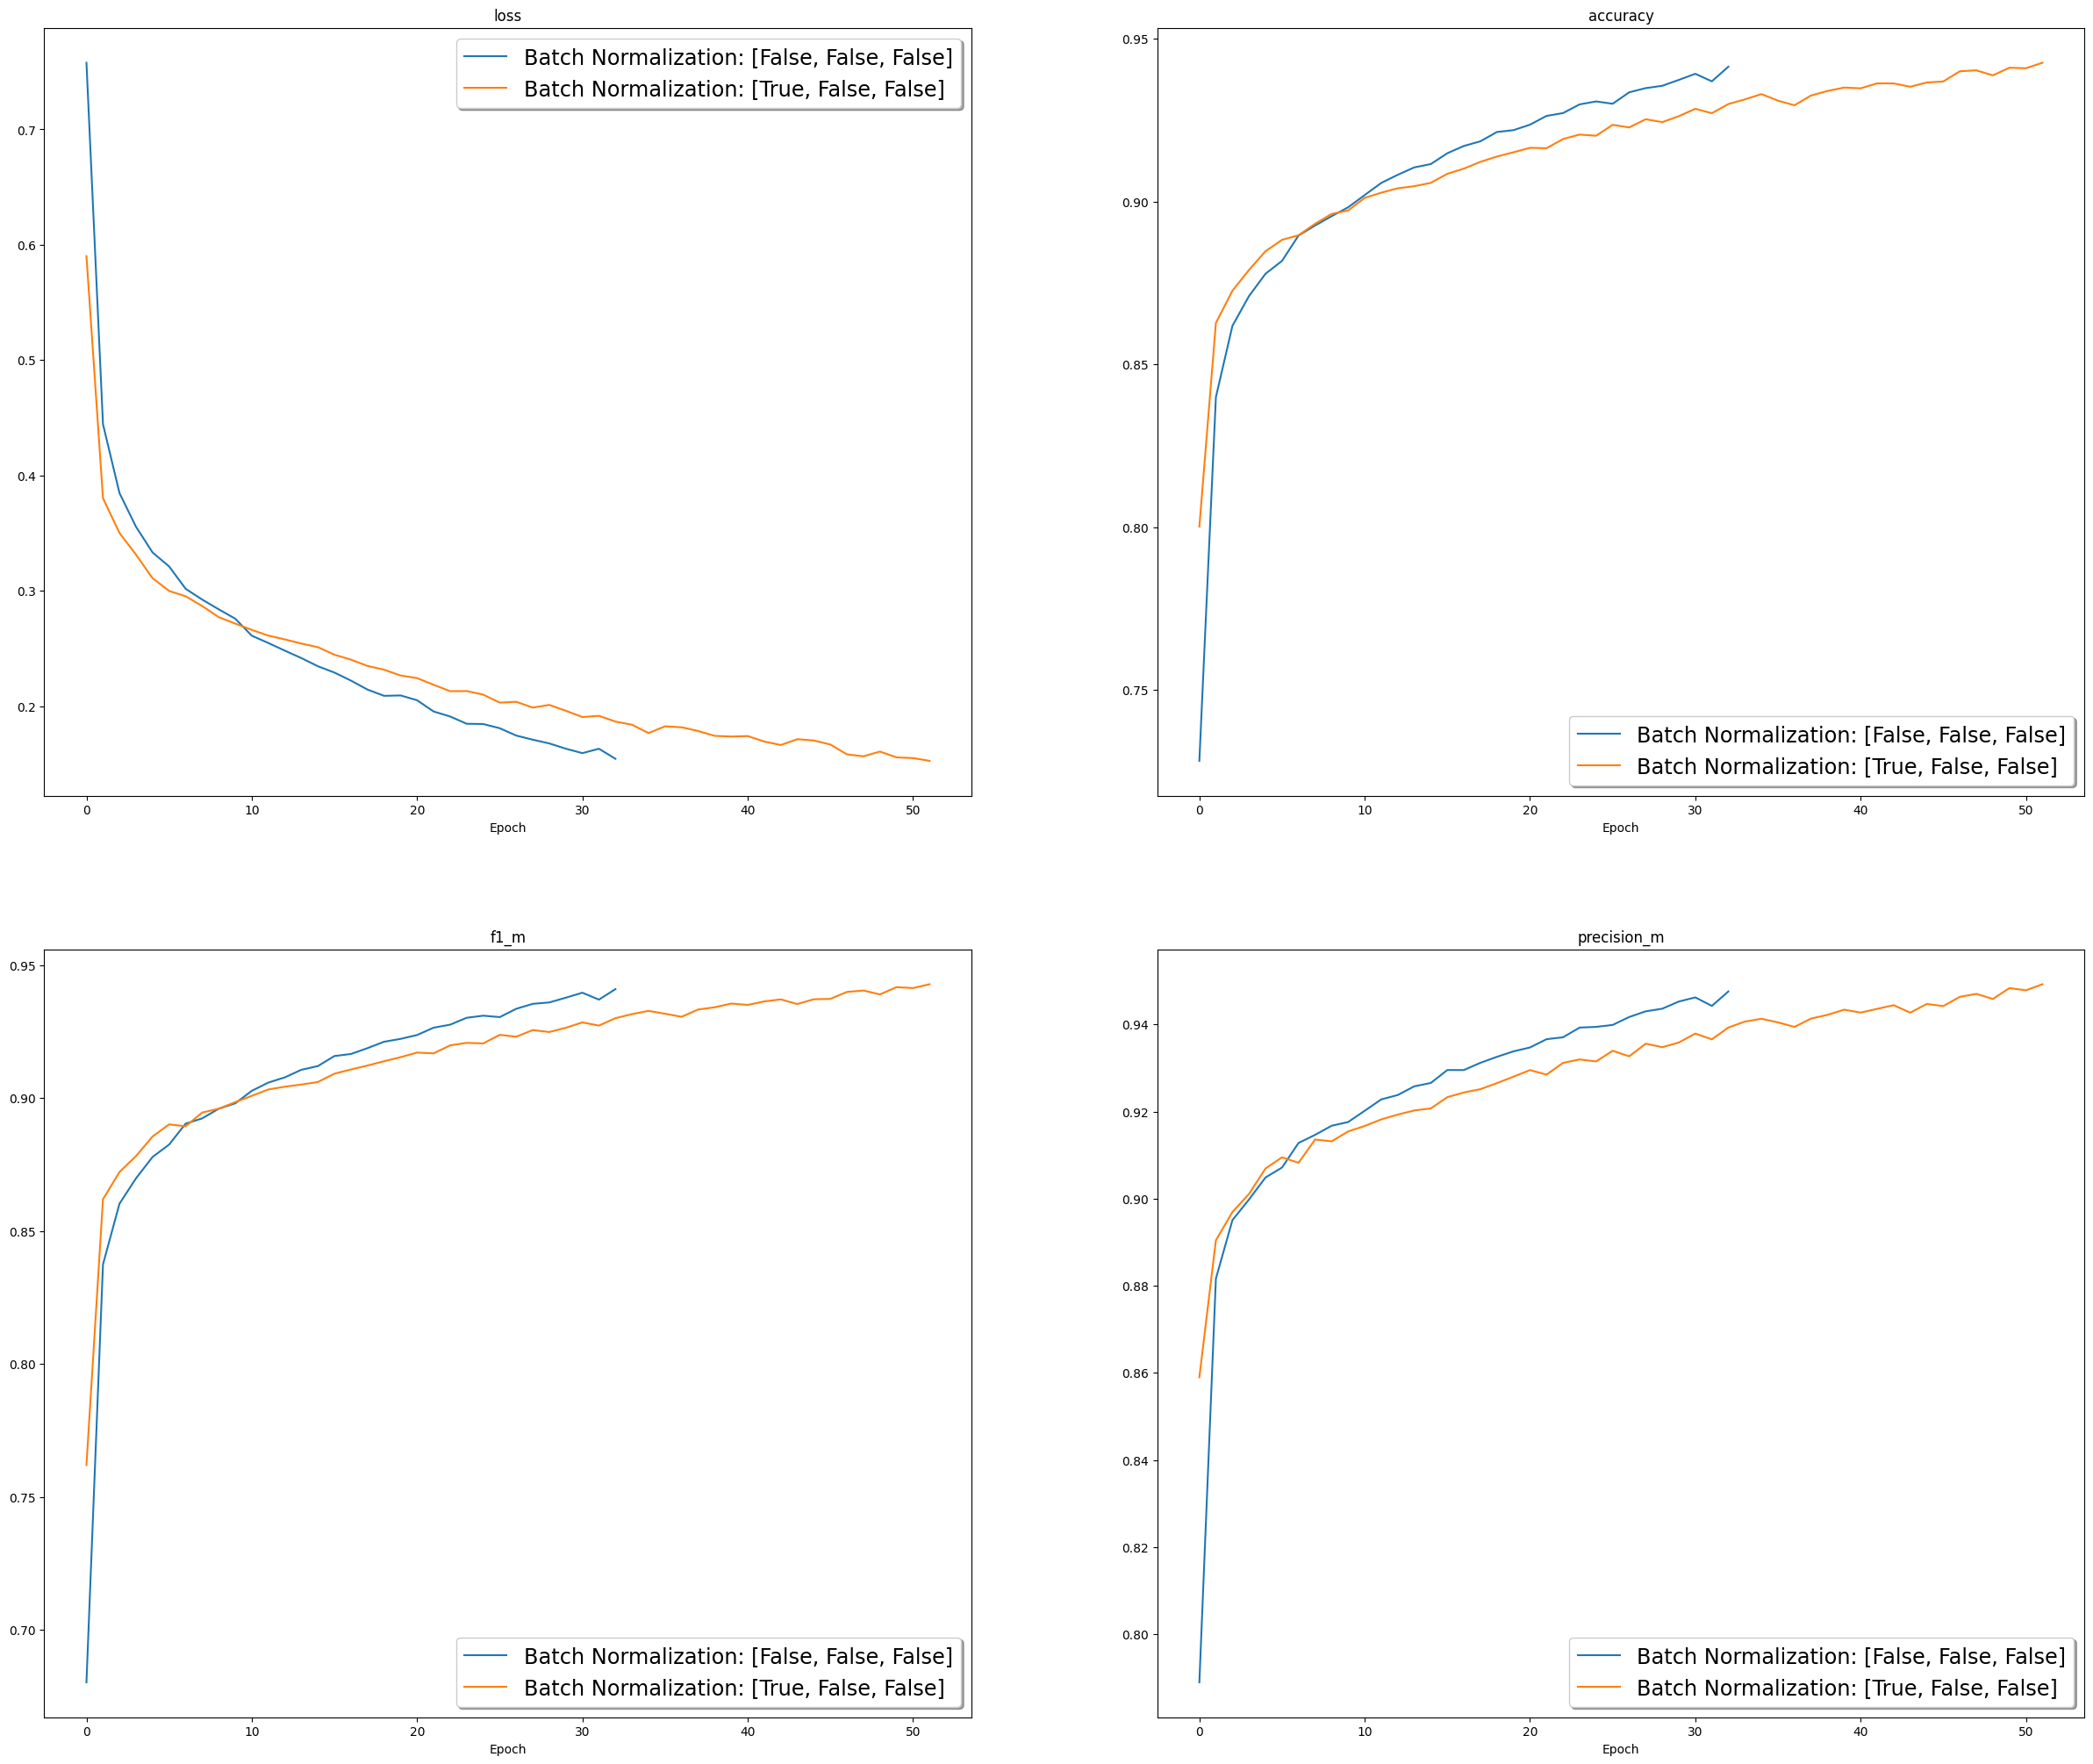

In [63]:
accuracies_array = np.array(accuracies_bn, dtype=object)
losses_array = np.array(losses_bn, dtype=object)

print("Max accuracy:", np.max(np.max(accuracies_array)), "at batch normalization =", batch_normalization[np.argmax(np.argmax(accuracies_array))])
print("Min loss:", np.min(np.max(losses_array)), "at batch normalization =", batch_normalization[np.argmin(np.argmax(losses_array))])

f, axis = plt.subplots(2, 2, figsize=(30, 25))
k = 0
for i in range(2):
    for j in range(2):
      for bn in range(len(batch_normalization)):
        axis[i,j].plot(histories_bn[bn][metrics[k][0][0]], label=f'Batch Normalization: {batch_normalization[bn]}')
        axis[i,j].grid()
        axis[i,j].set_xlabel('Epoch')
        axis[i,j].legend(shadow=True, fontsize='xx-large')
        axis[i,j].set_title(metrics[k][0][1])
      k += 1
plt.show()

It is kind of confusing because seing in the figures we can check that effectively adding a batch normalization layer improves the performance.